# Imports

In [60]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
import umap.umap_ as umap

#metricas
import sklearn.metrics
import scikitplot                         as skplt
from scipy                 import stats
from sklearn               import manifold as mn
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

#modelos
from sklearn.ensemble     import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn              import mixture      as mx
from scipy.cluster        import hierarchy     as hr
from sklearn.neighbors    import NearestNeighbors
from sklearn              import decomposition as  dcp
from sklearn              import cluster       as c

## Helper functions

In [61]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [62]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [64]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# Load data 

In [65]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'

In [66]:
df7 = pd.read_csv(path_local + 'data/processed/df5.csv')

In [67]:
df7.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response
0,5524,0.22,0.351086,0.585859,0.425318,0.442211,0.554878,0.664093,0.335878,0.274143,0.200000,0.296296,0.909091,0.307692,0.35,0,0,0,0.696429,1,0.948498,0.373613,0.639683,0,1
1,2174,0.22,0.277680,0.383838,0.007368,0.005025,0.006098,0.007722,0.003817,0.018692,0.133333,0.037037,0.090909,0.153846,0.25,0,0,0,0.750000,3,0.161660,0.094444,0.008730,0,0
2,4141,0.25,0.434956,0.262626,0.285332,0.246231,0.129065,0.428571,0.080153,0.130841,0.066667,0.296296,0.181818,0.769231,0.20,0,0,0,0.553571,2,0.446352,0.227577,0.305952,0,0
3,6182,0.25,0.155079,0.262626,0.007368,0.020101,0.020325,0.038610,0.011450,0.015576,0.133333,0.074074,0.000000,0.307692,0.30,0,0,0,0.214286,3,0.198856,0.051506,0.019048,0,0
4,5324,0.39,0.352051,0.949495,0.115874,0.216080,0.119919,0.177606,0.103053,0.046729,0.333333,0.185185,0.272727,0.461538,0.25,0,0,0,0.267857,3,0.230329,0.120491,0.165476,0,0


# Select columns 

**Para a segmentação de clientes algumas variaveis serão deixadas de lado nesse momento**

In [68]:
df_ref = df7[['id','response']]

In [69]:
cols_selected = ['id','income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'age','n_family_members', 'days_since_signup', 'income_per_member',
       'total_spent']
df8 = df7[cols_selected]

# Estudo do espaço

In [70]:
X = df8.copy()
X = X.drop(columns='id')

## PCA

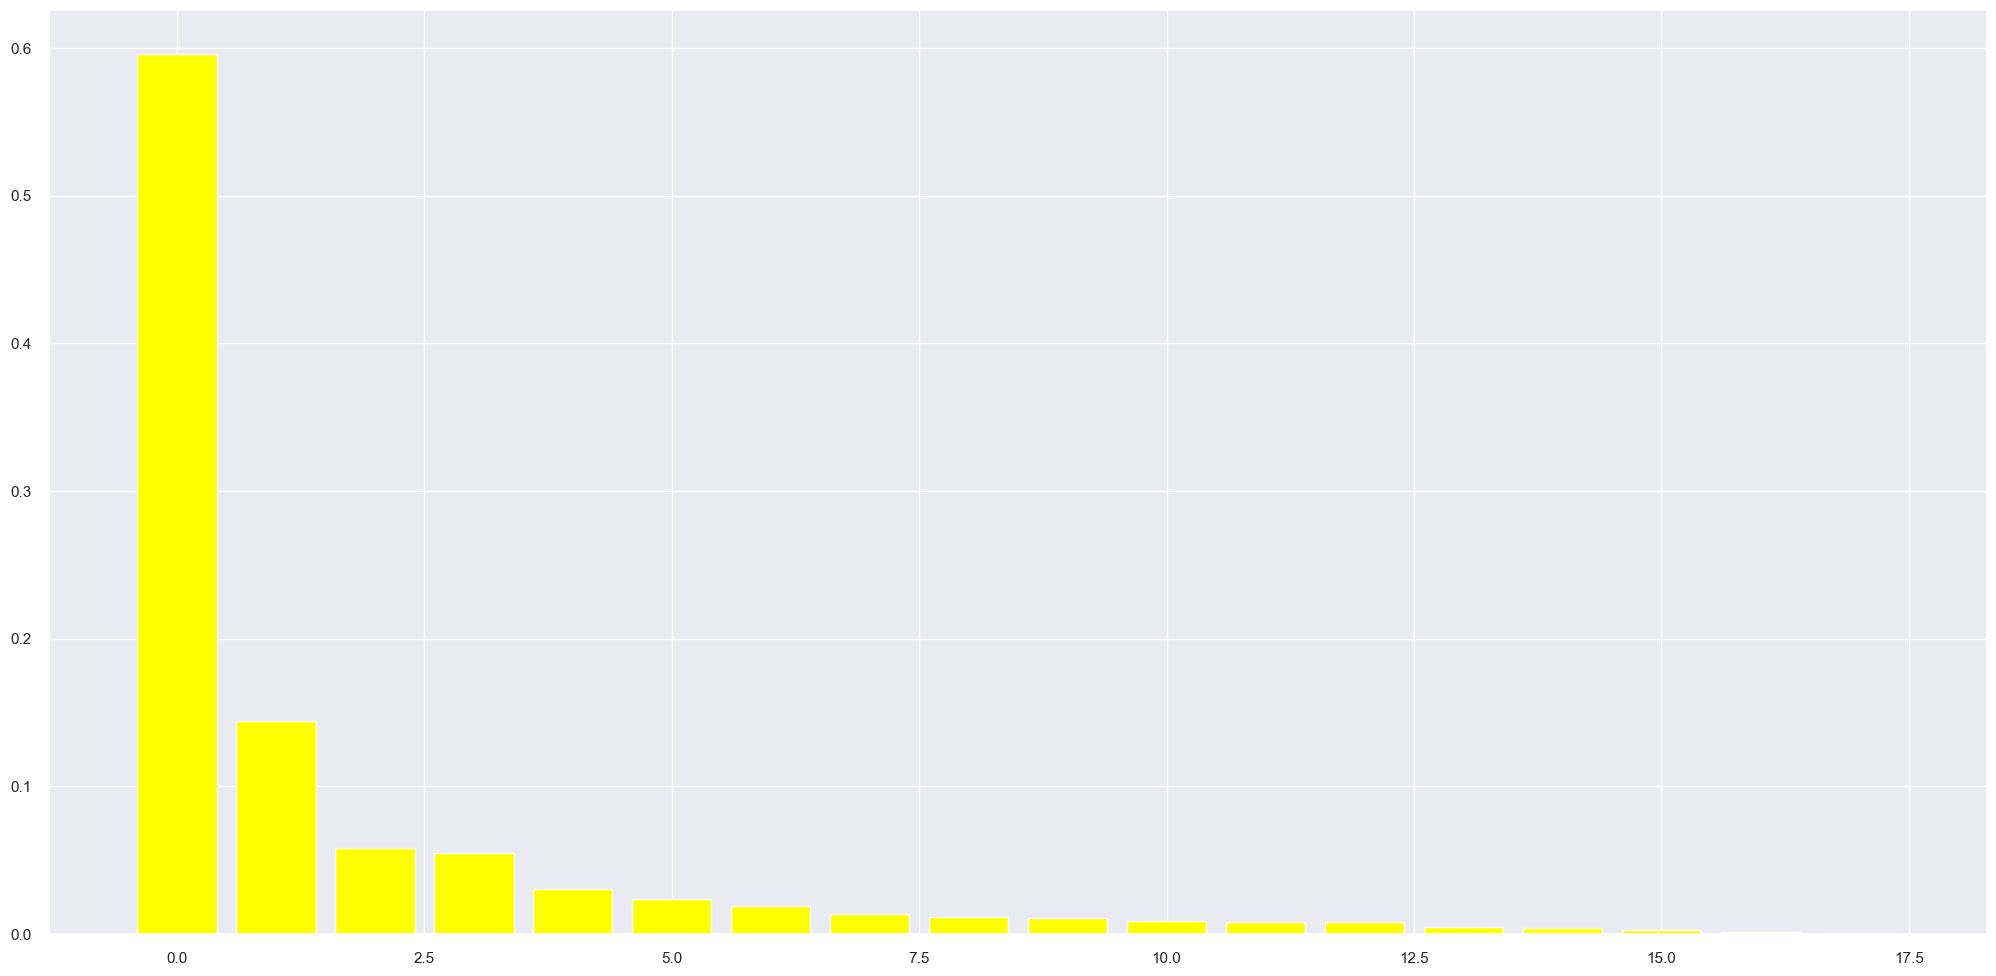

In [71]:
pca = dcp.PCA(n_components = X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_,color='yellow')

#pcs componentes
df_pca = pd.DataFrame(principal_component)

<AxesSubplot: xlabel='0', ylabel='1'>

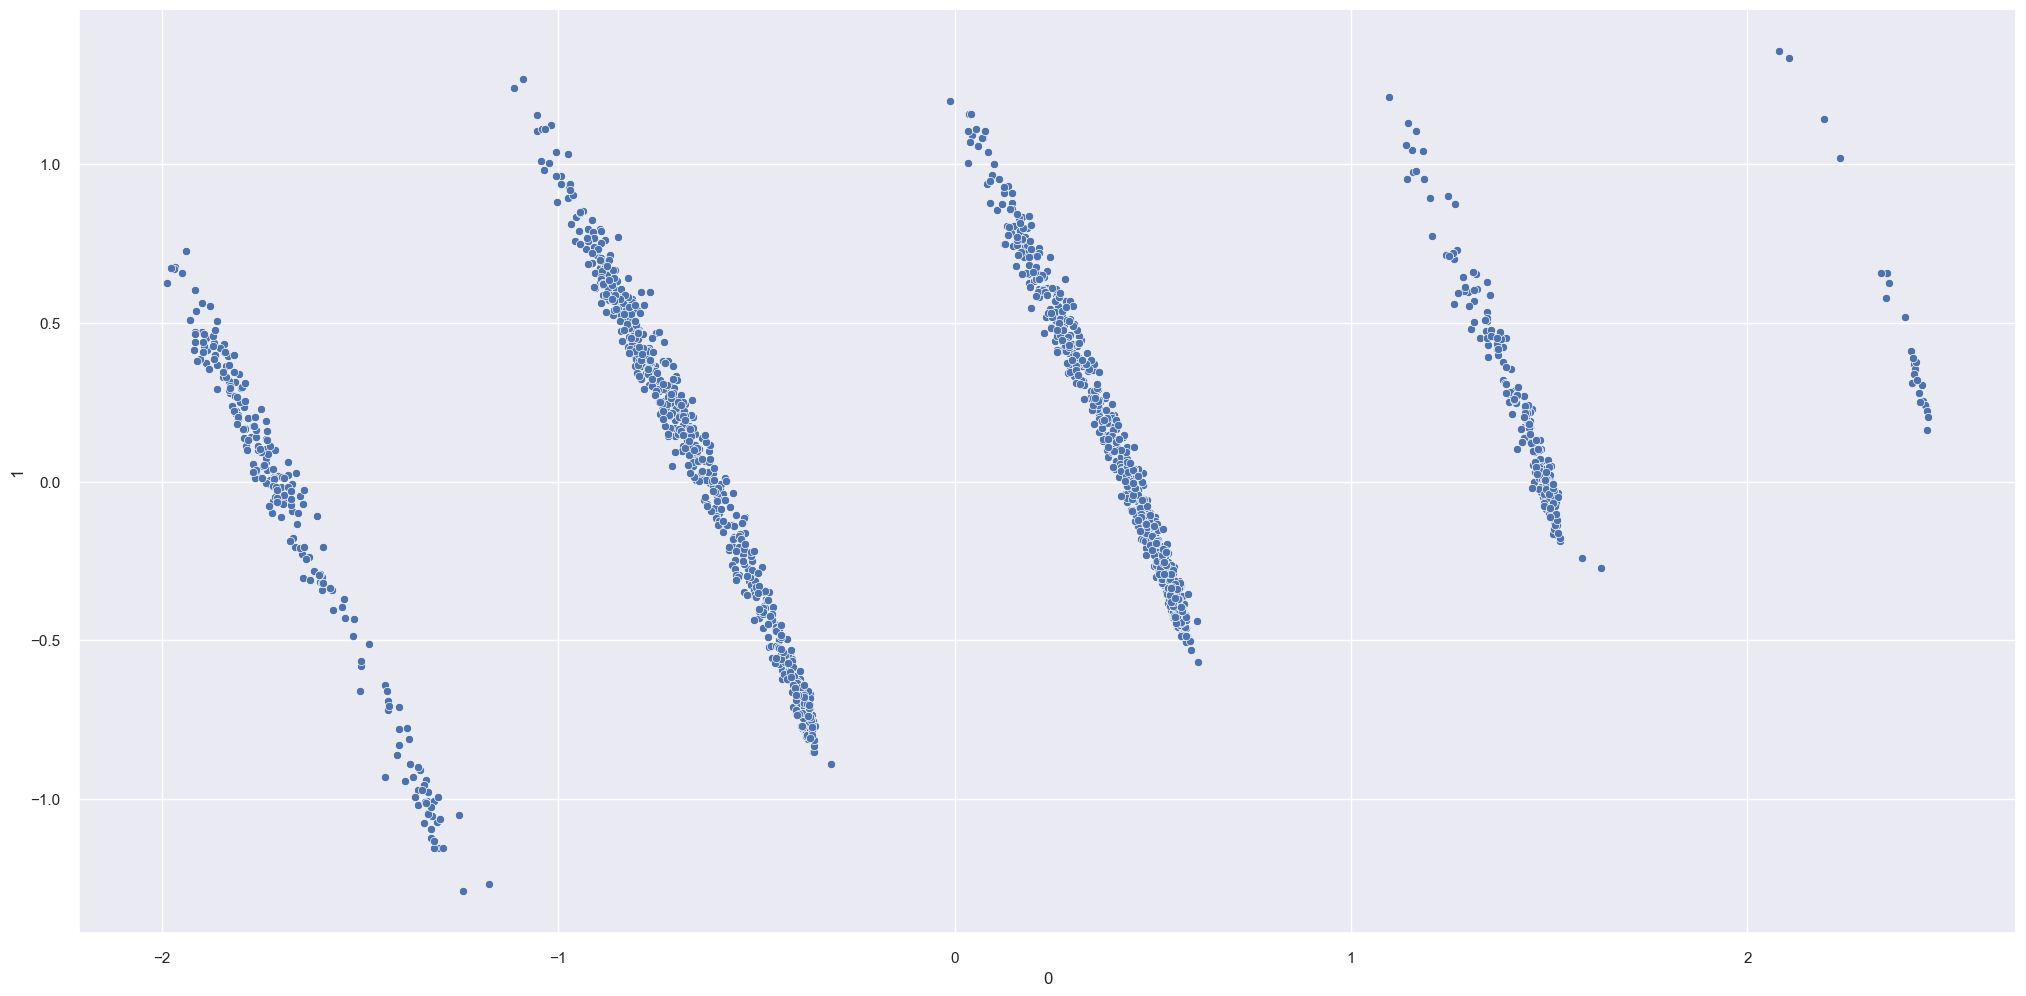

In [72]:
sns.scatterplot(x=0,y=1,data=df_pca)

## Umap

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

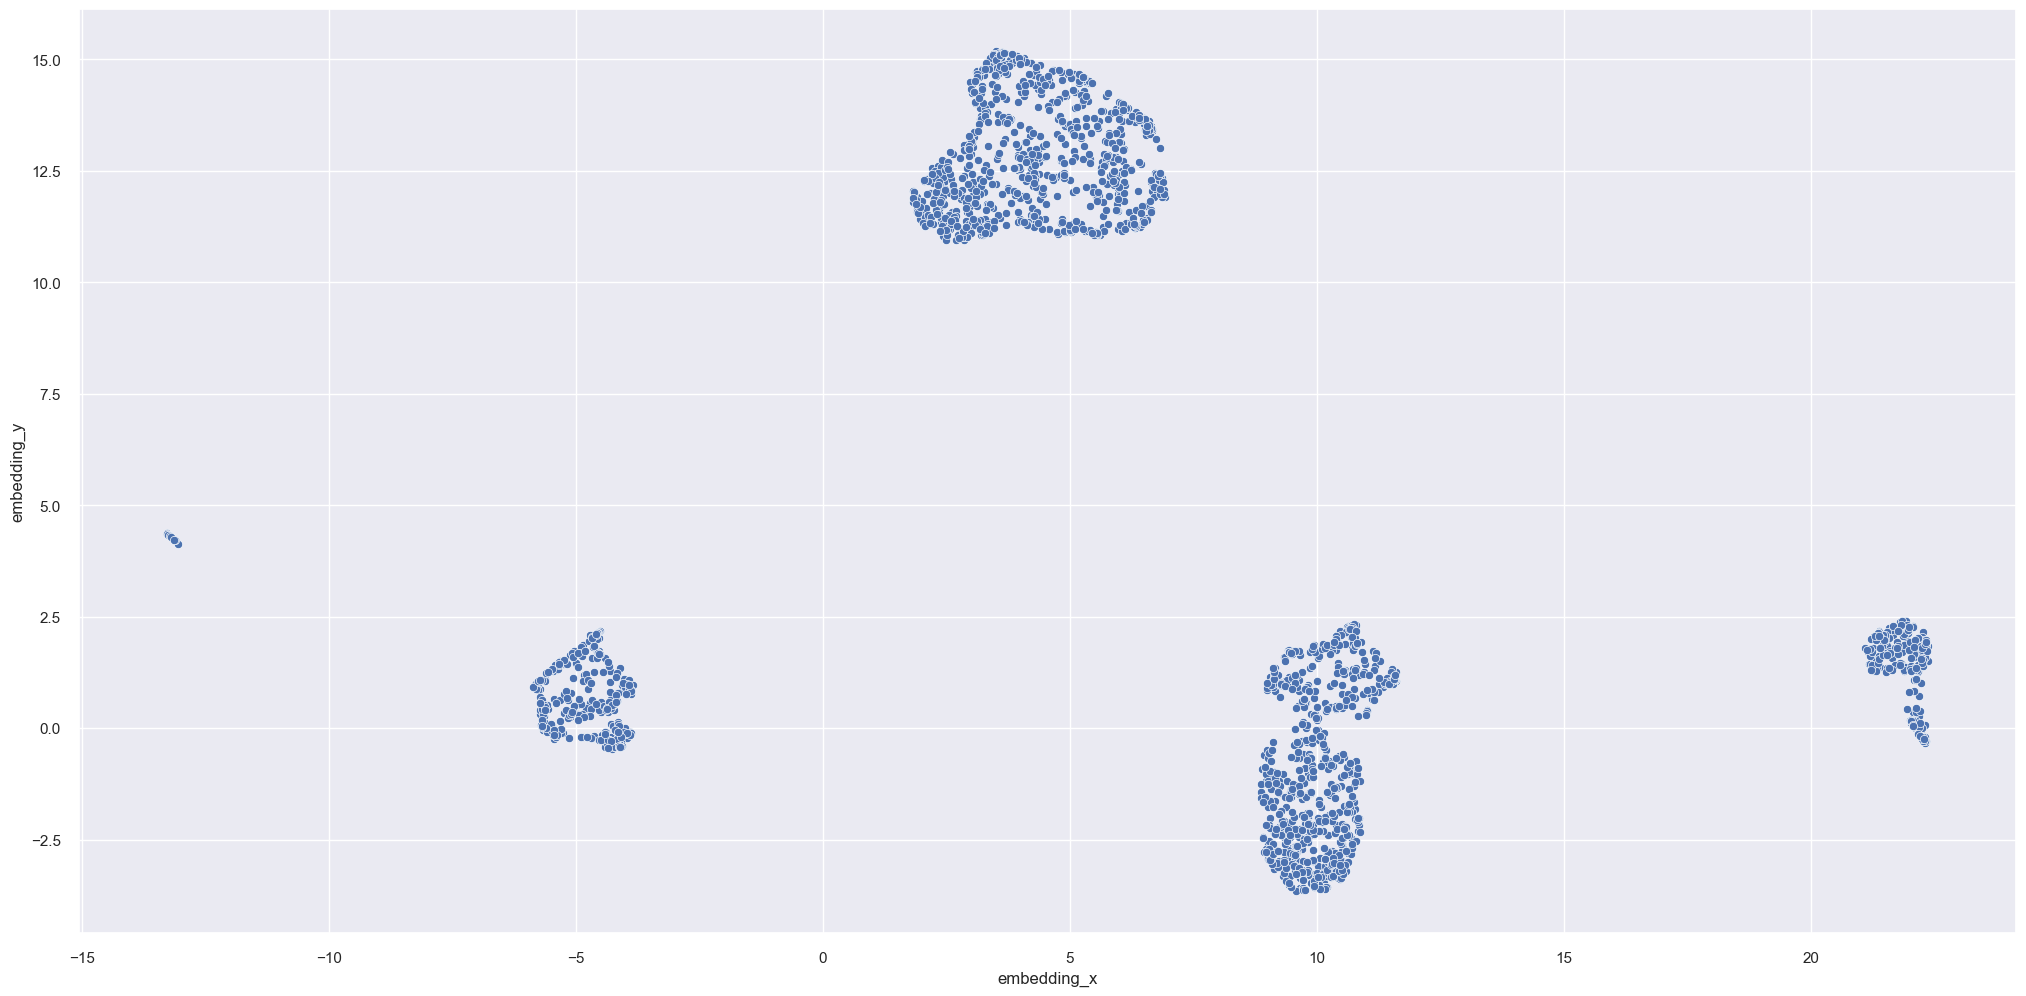

In [73]:
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_umap = pd.DataFrame()

df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_umap)

## T-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

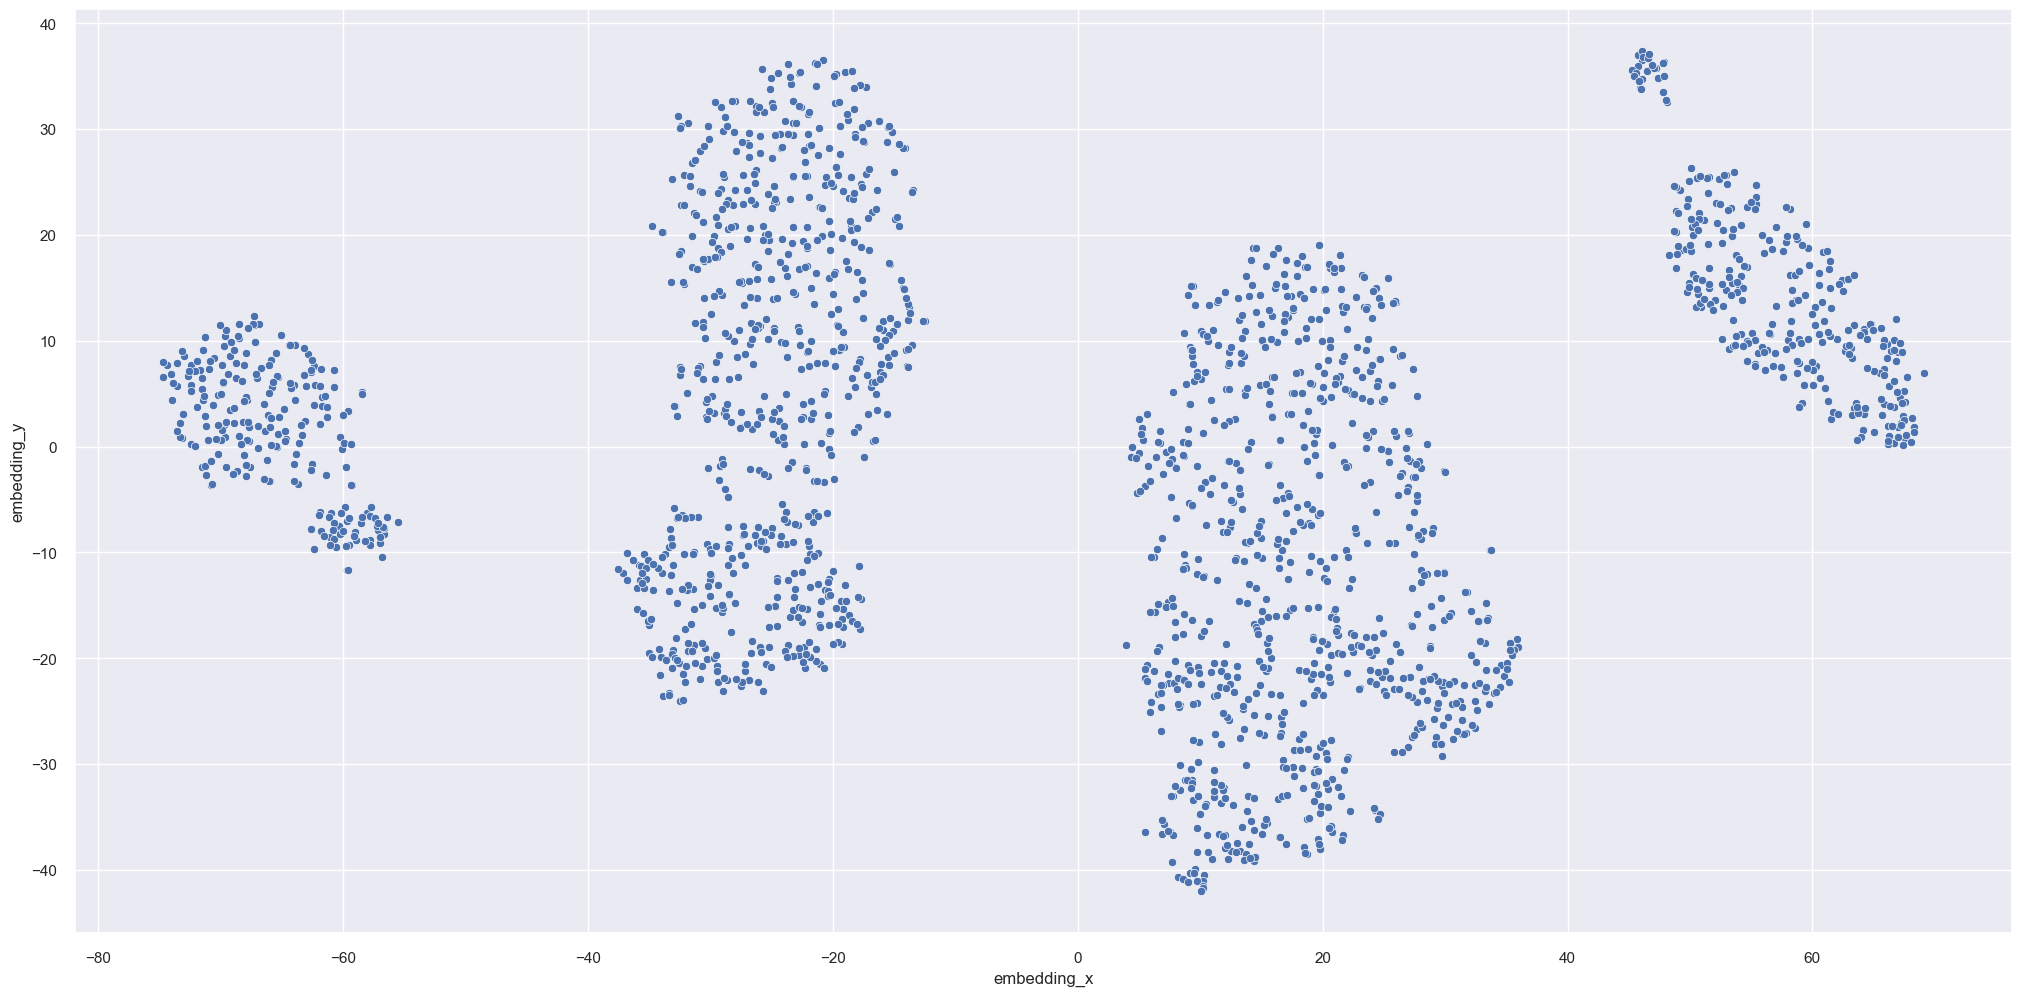

In [74]:
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2,n_jobs=-1,random_state=42)
embedding = reducer.fit_transform(X)


#embedding
df_tsne = pd.DataFrame()

df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_tsne)

## tree-based embedign

In [75]:
X = df8.drop(['id','total_spent'],axis=1)
y = df8['total_spent']


# model definition
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)

#model training
rf_model.fit(X,y.values)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
#dataframe Leaf

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

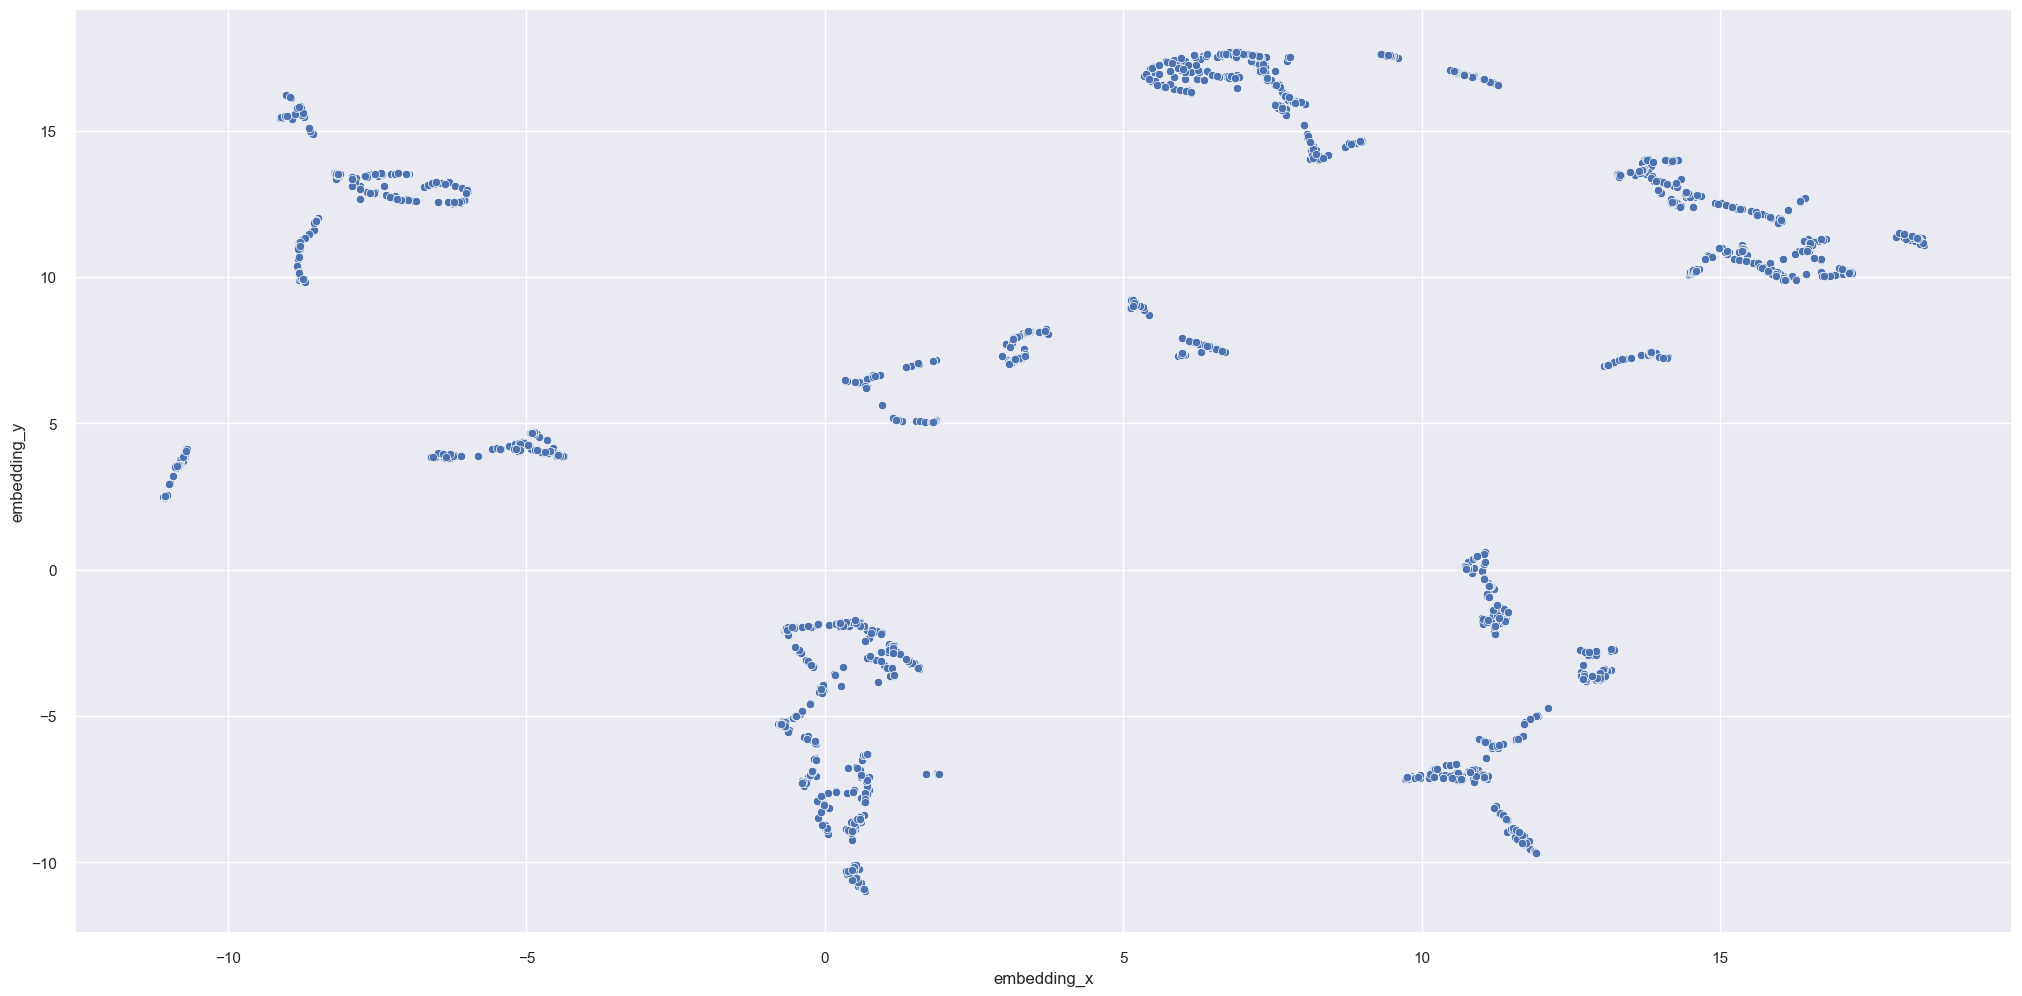

In [76]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)


#embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]


sns.scatterplot(x='embedding_x', y ='embedding_y',data=df_pca)

# Fine tuning 

In [77]:
#X = df8.drop(columns='id')
X = df_umap

In [78]:
X.head()

,embedding_x,embedding_y
0,22.254139,2.159944
1,5.301864,11.141860
2,10.760339,-1.825446
3,6.456731,11.714489
4,3.393605,13.992409


In [79]:
clusters = [2,3,4,5,6,7]

## k-means

In [80]:
sil_k = []
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Within-Cluster Sum of Square (WSS)**

In [81]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

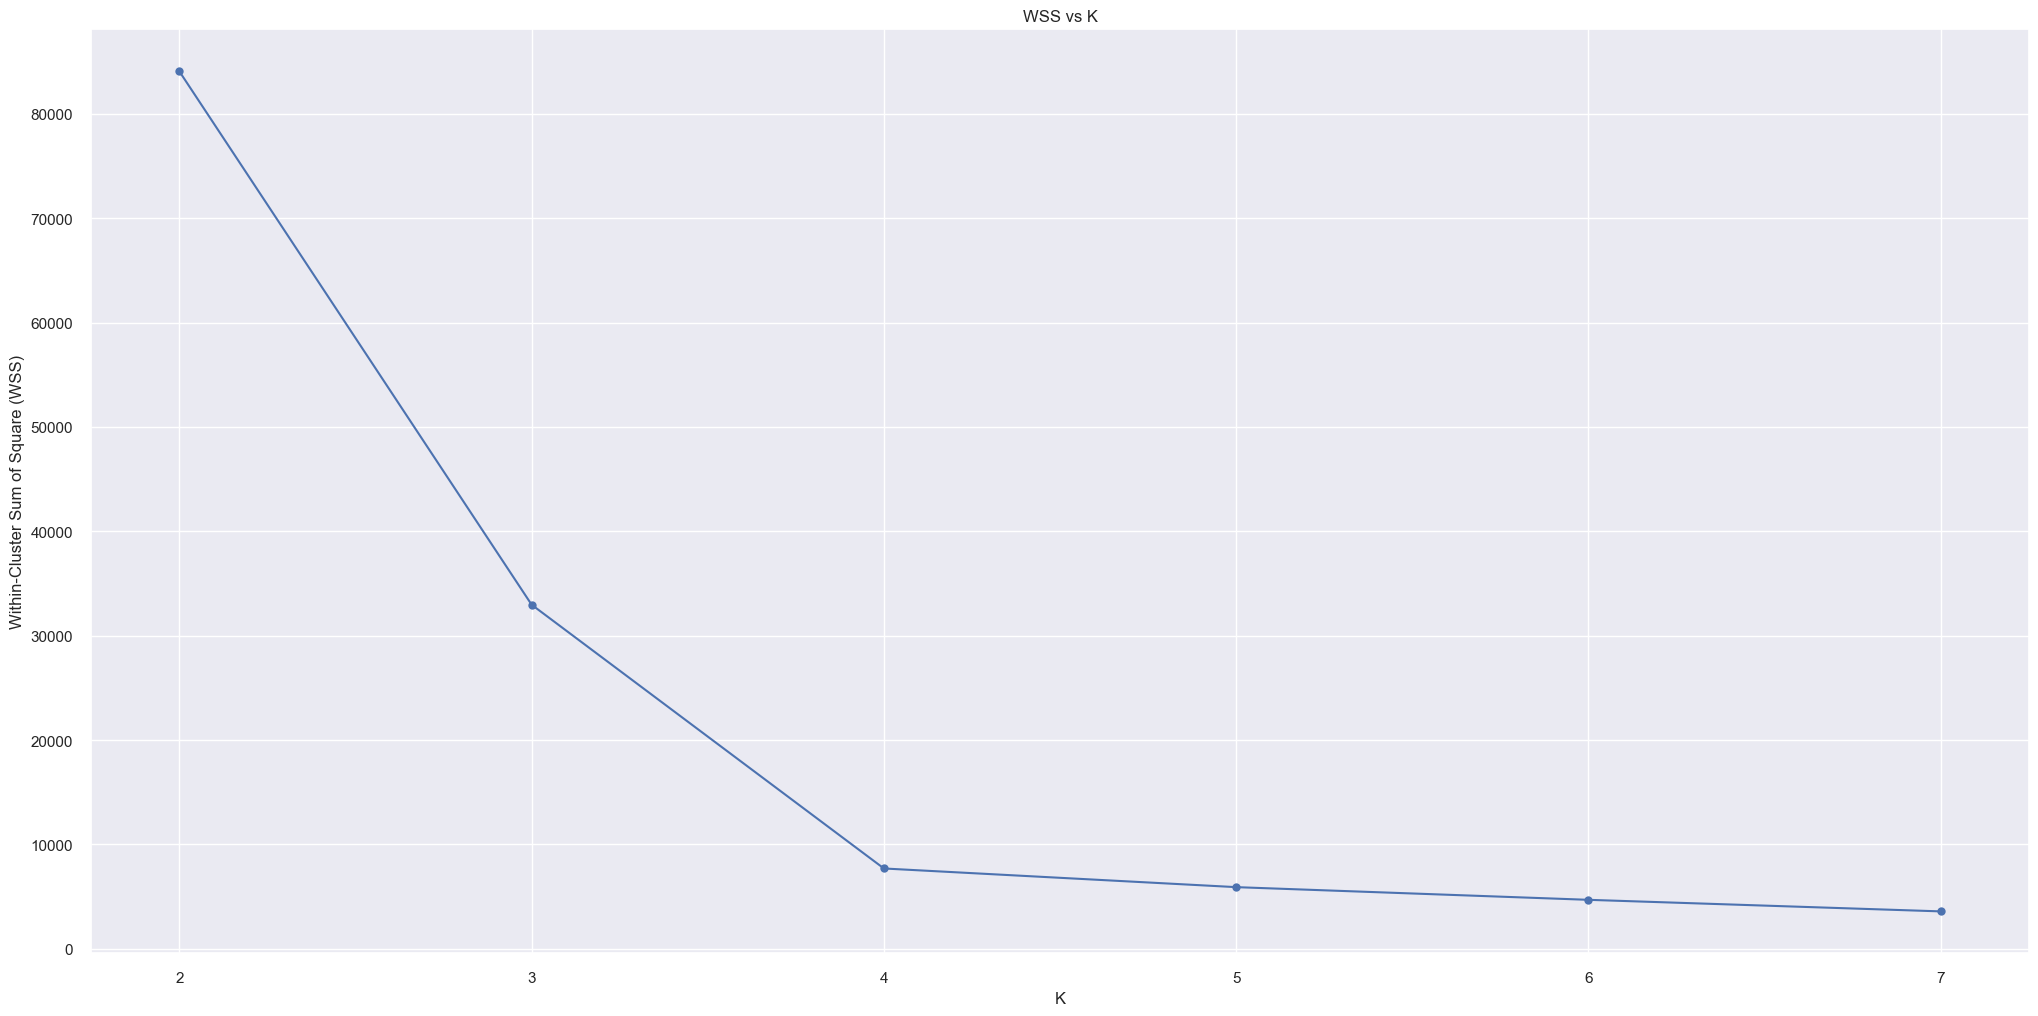

In [82]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

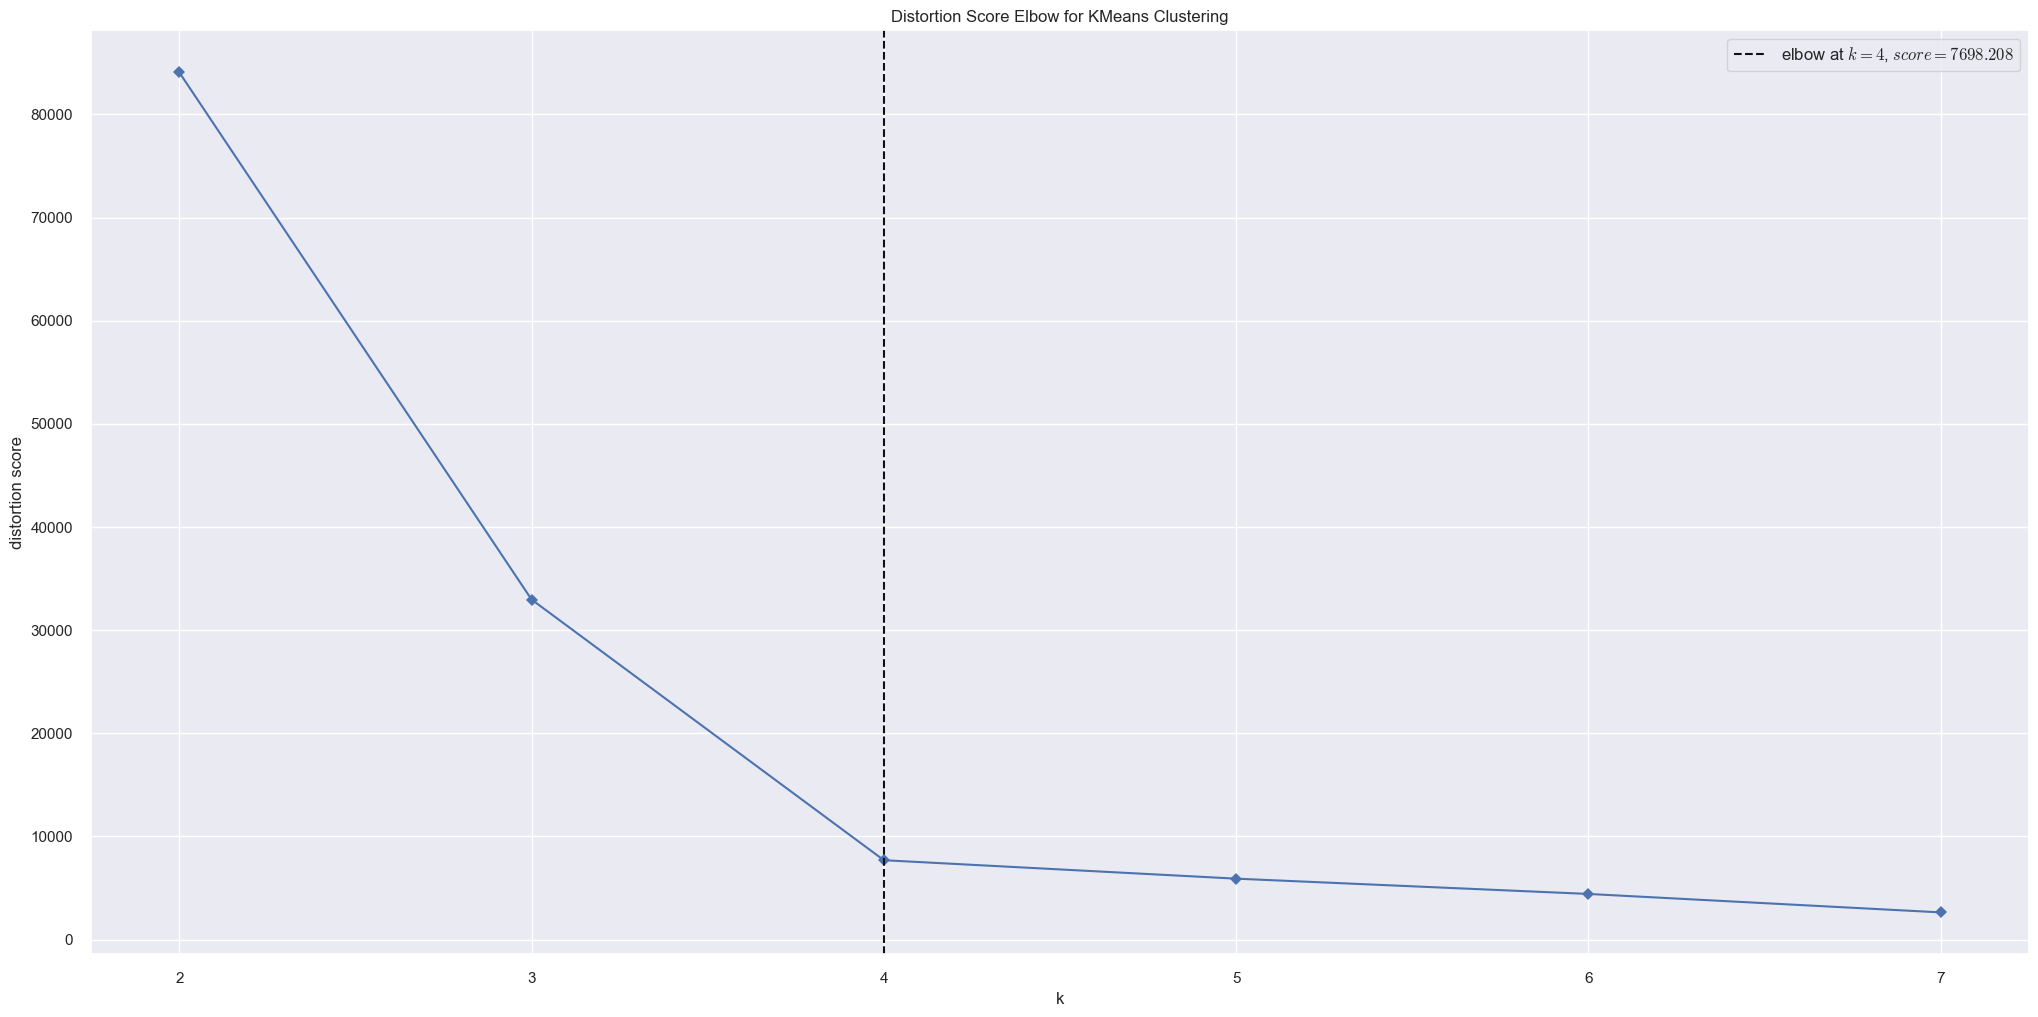

In [83]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

**Sillhouete Score**

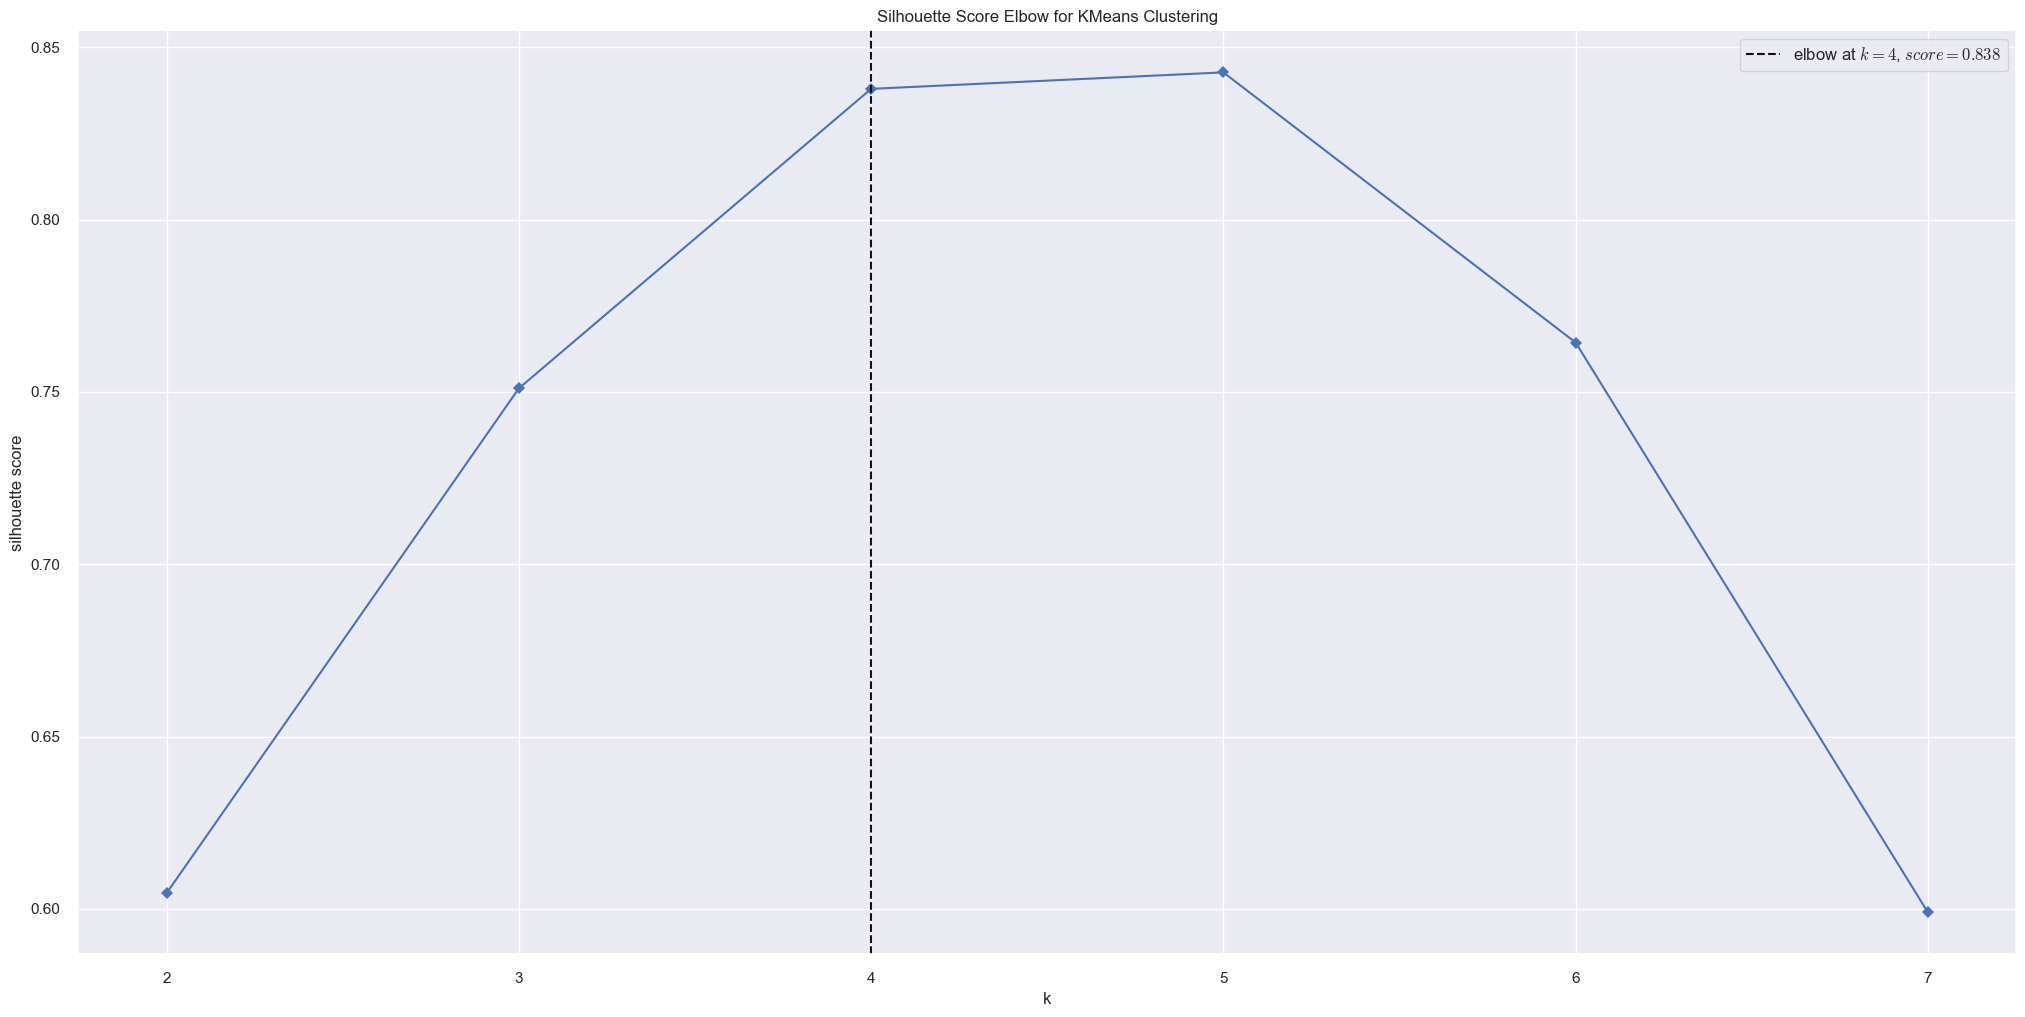

In [84]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

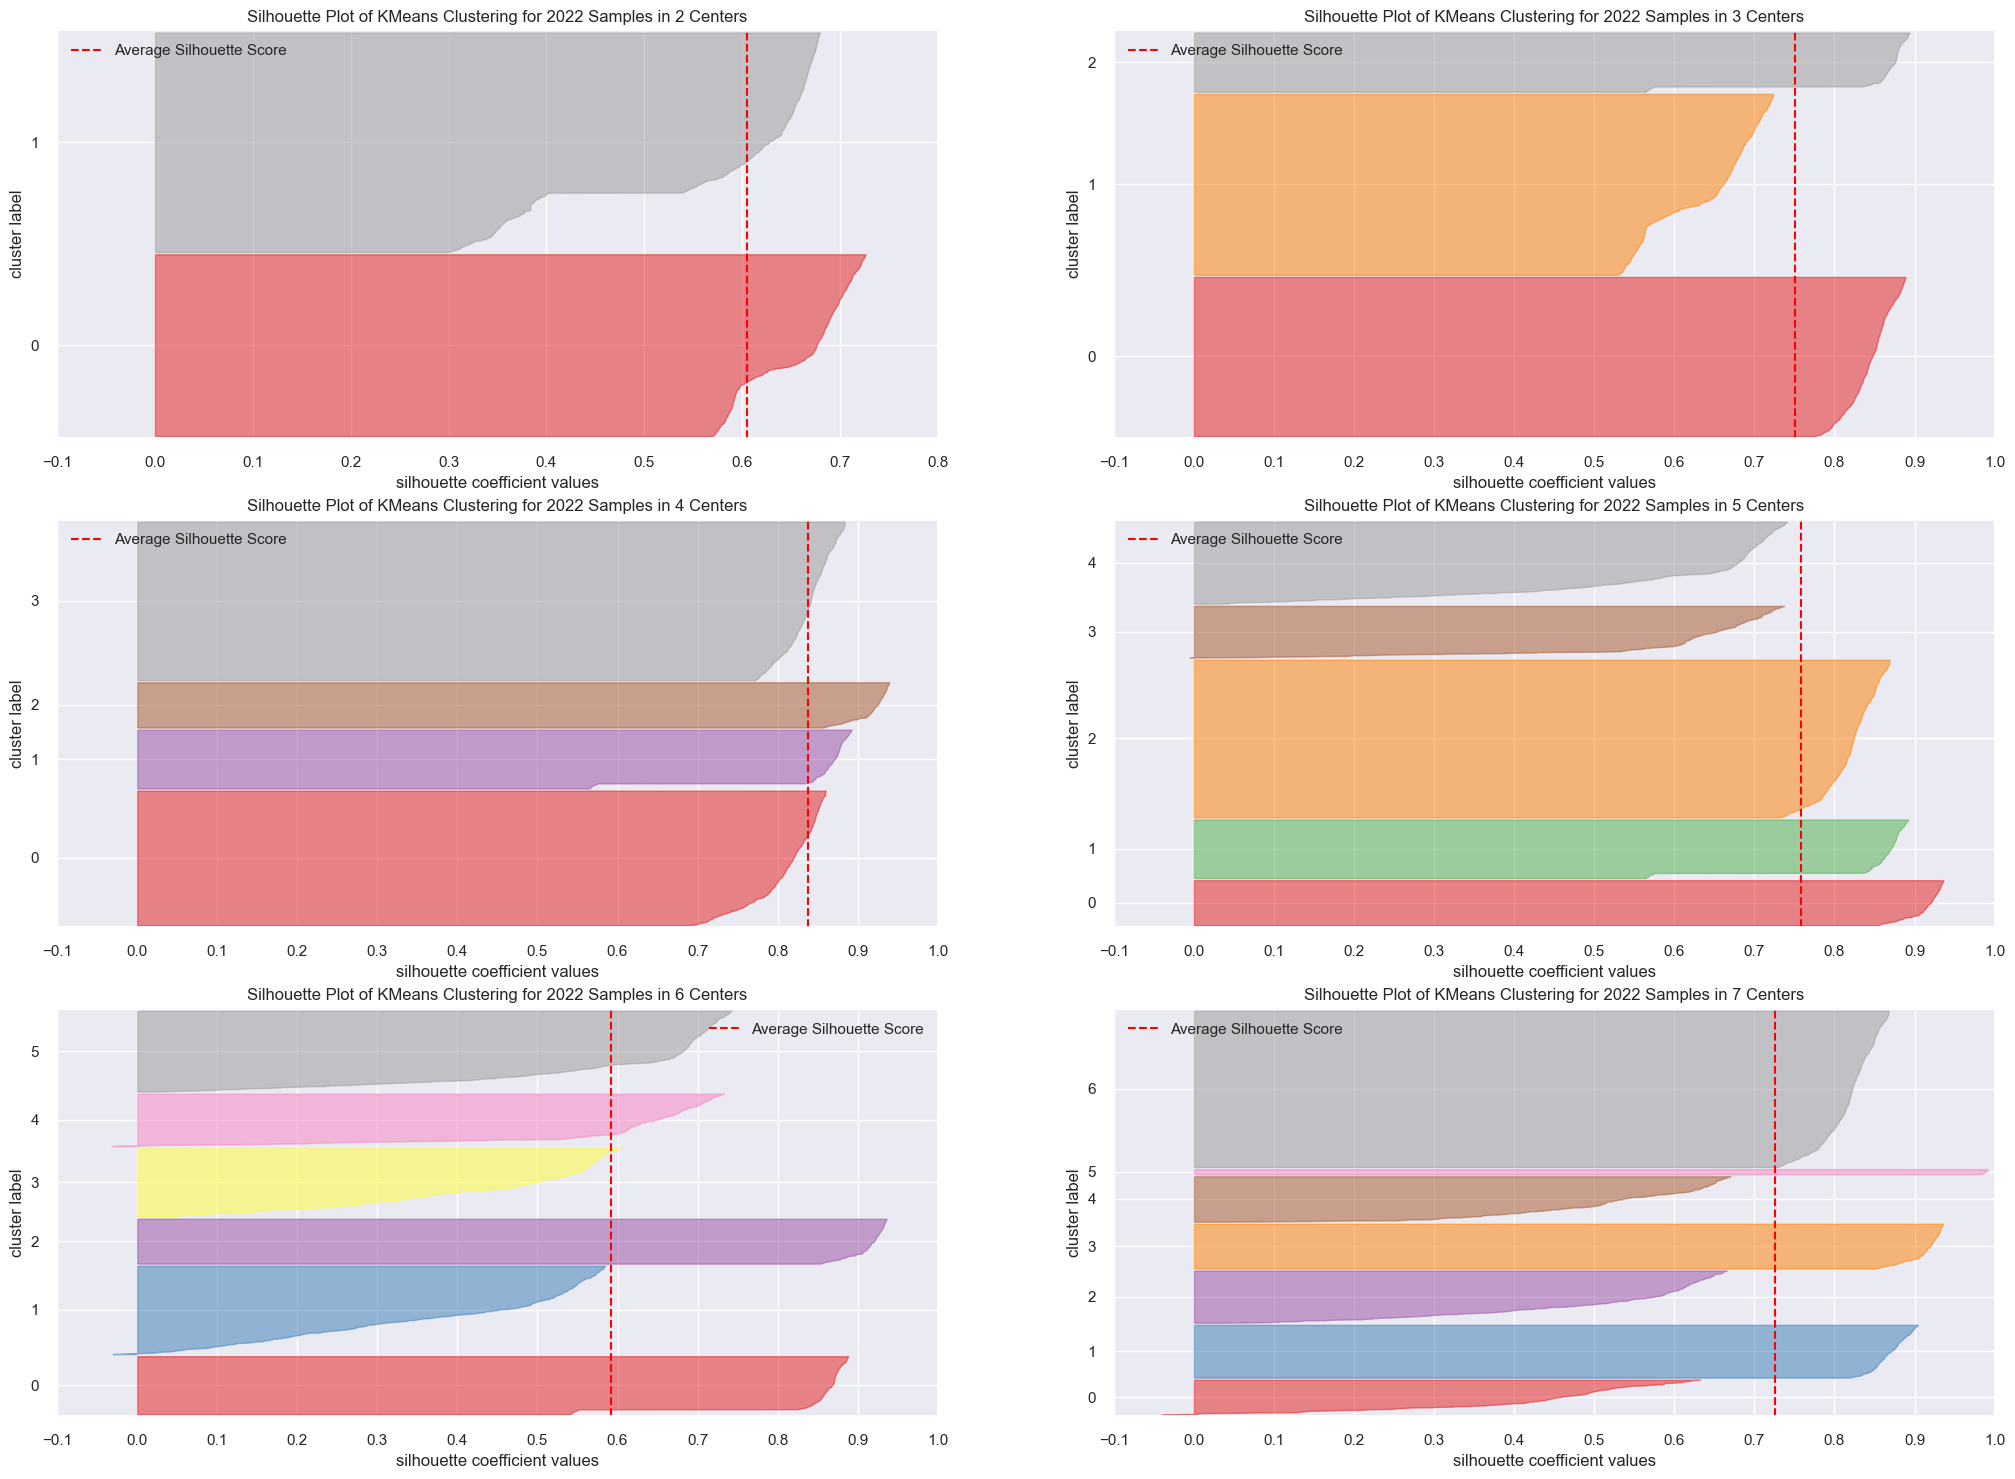

In [85]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,i = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][i])
    visualizer.fit(X)
    visualizer.finalize()

## GMM

AIC - ajuste do modelo
BIC - ajuste dos parametros

In [86]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

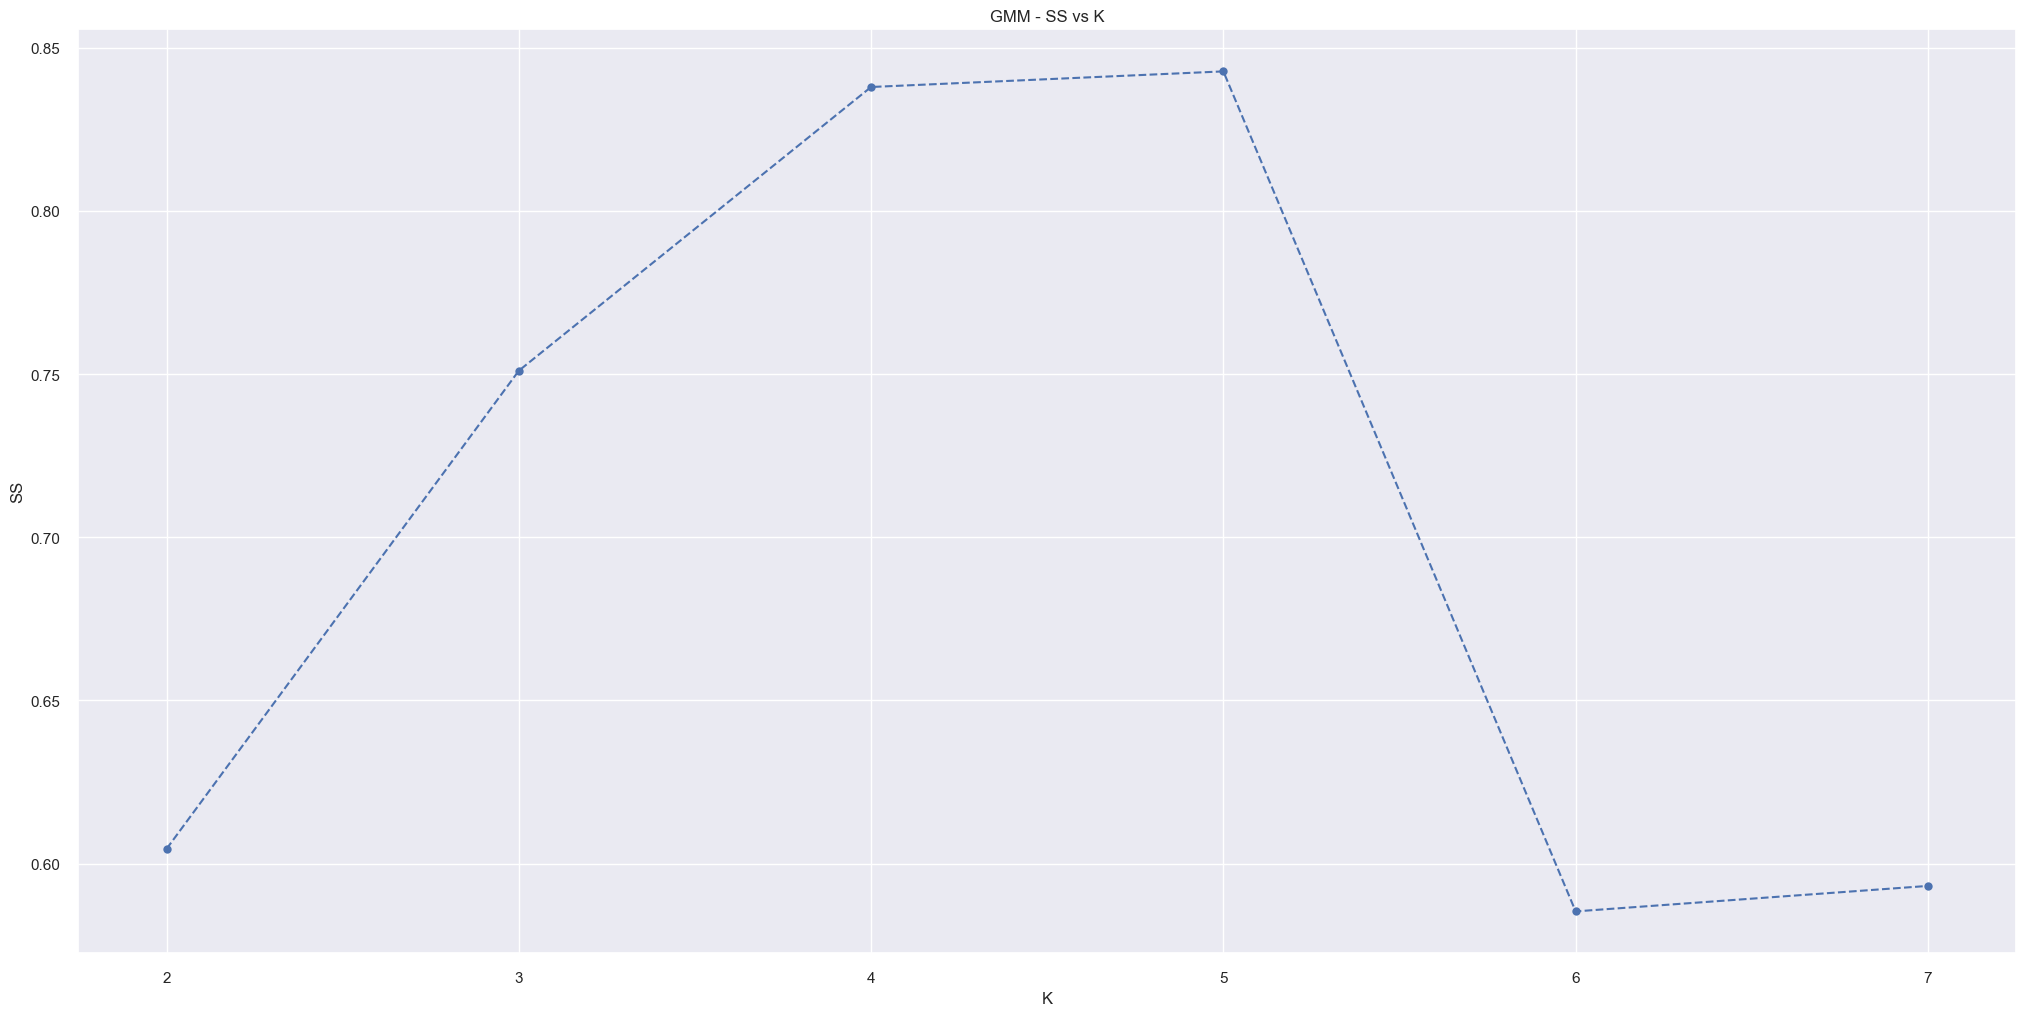

In [87]:
plt.plot(clusters,gmm_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('GMM - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.4582659900188446
For K = 3 Silhouette: 0.7510413527488708
For K = 4 Silhouette: 0.8379771113395691
For K = 5 Silhouette: 0.757621169090271
For K = 6 Silhouette: 0.5900147557258606
For K = 7 Silhouette: 0.619911789894104


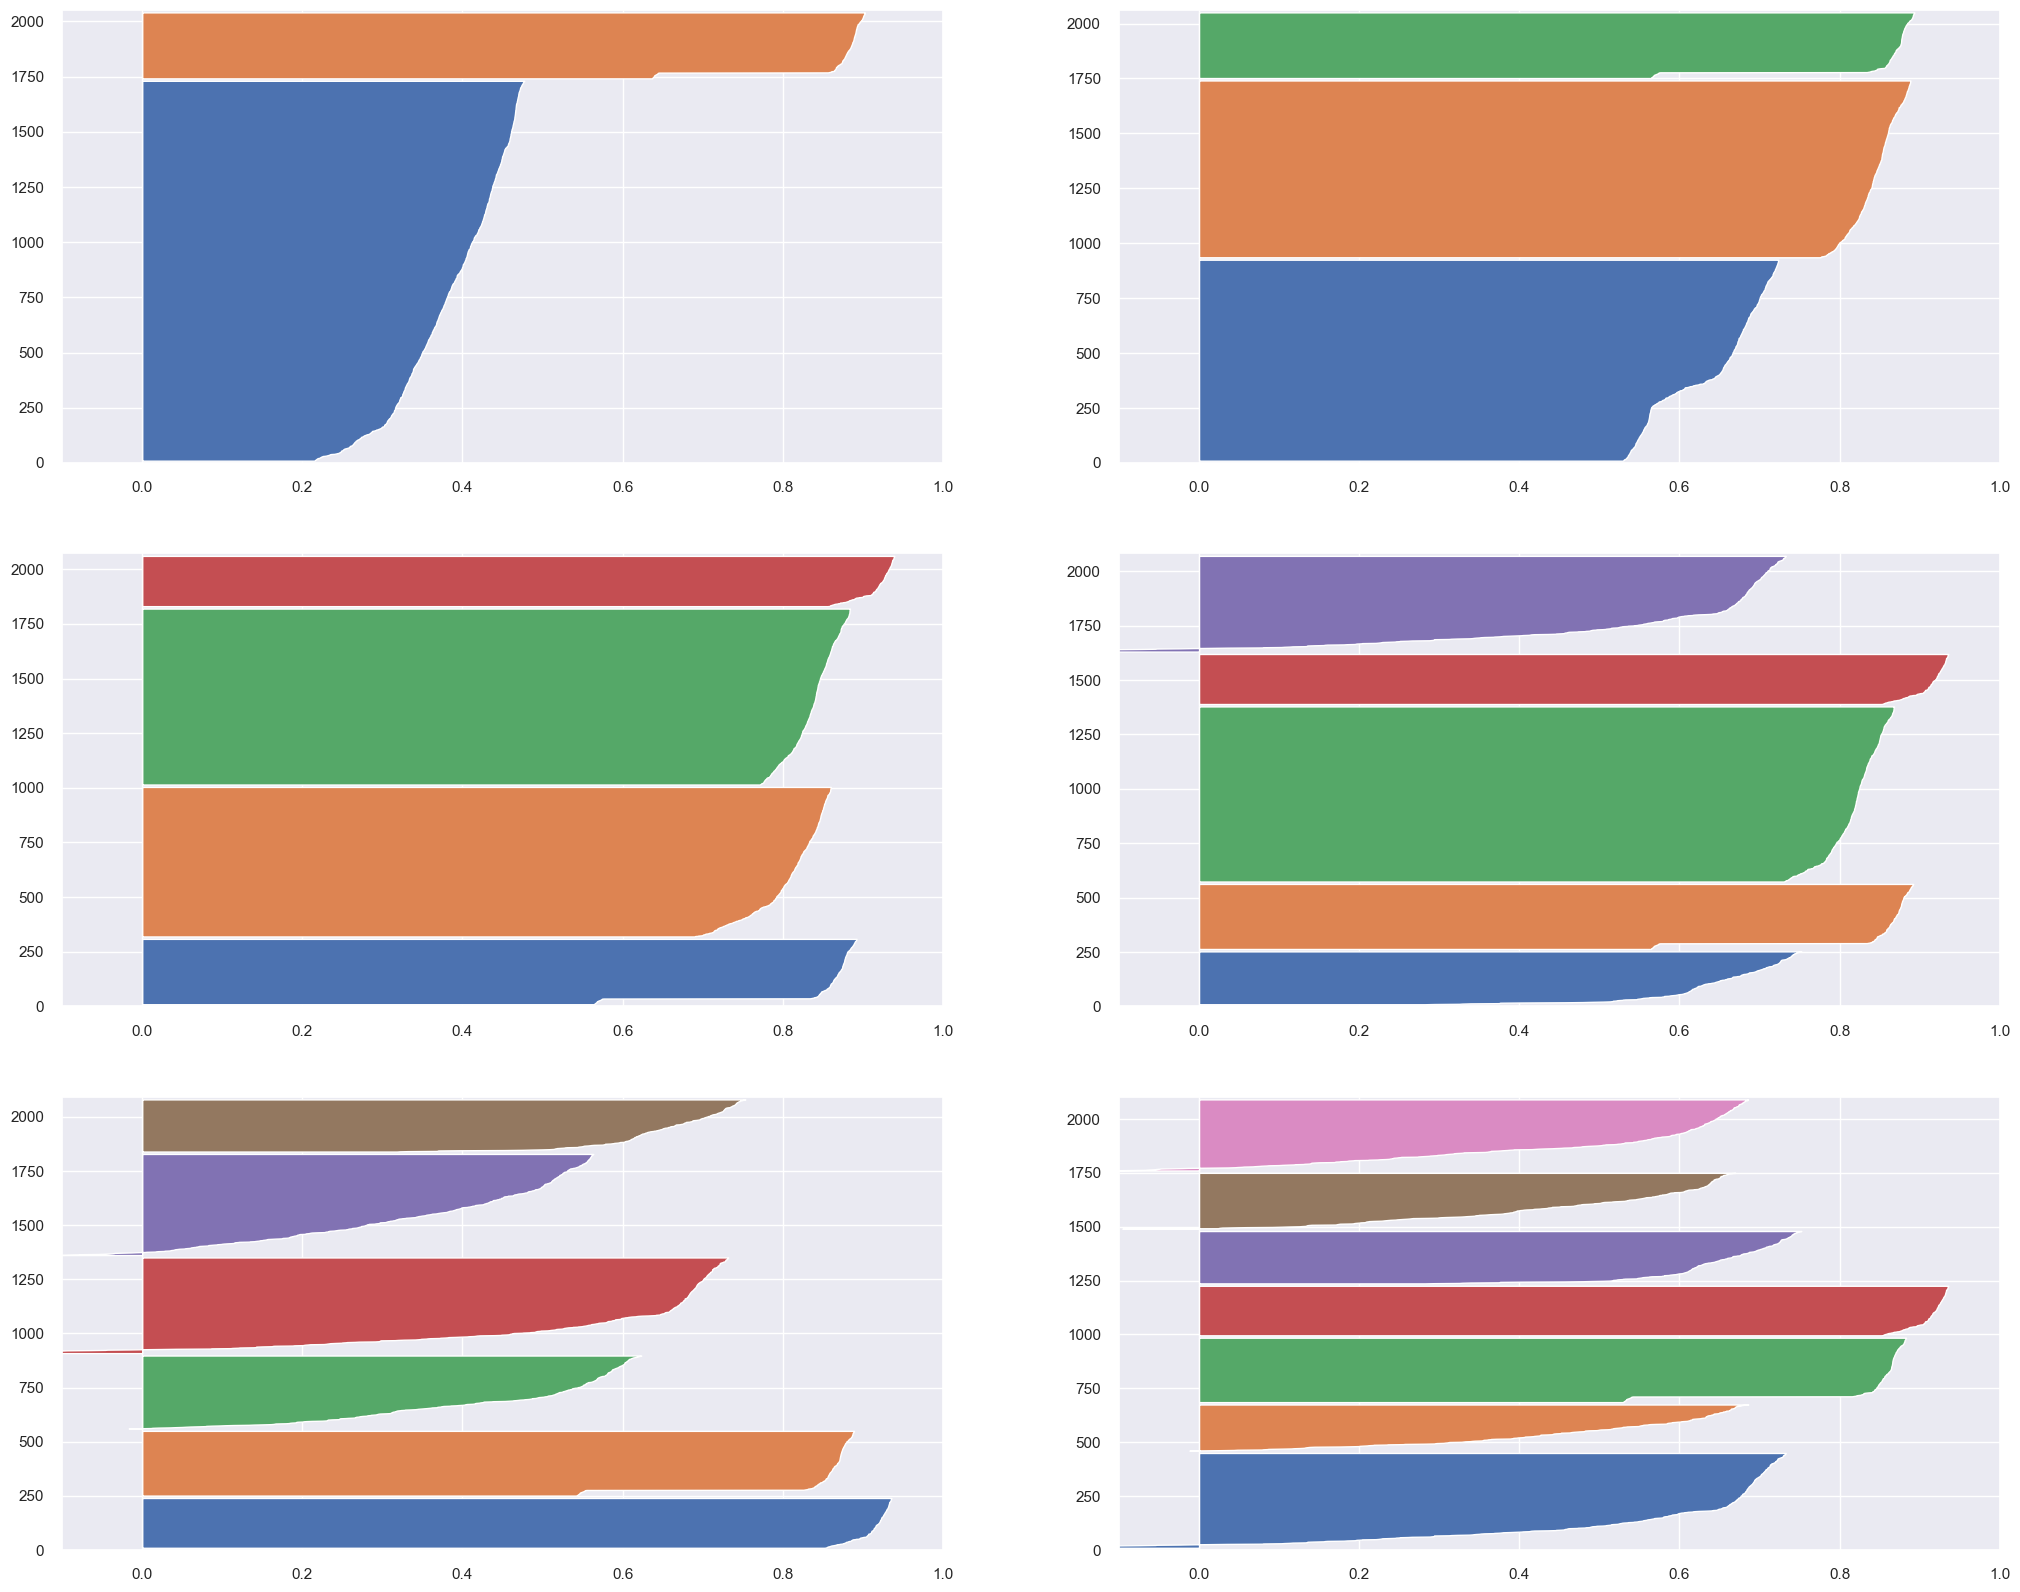

In [88]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k = sklearn.metrics.silhouette_score(X,labels,metric='euclidean')
    print(f'For K = {k} Silhouette: {gmm_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## H-Clustering

In [89]:
hc_model = hr.linkage(X,'ward')

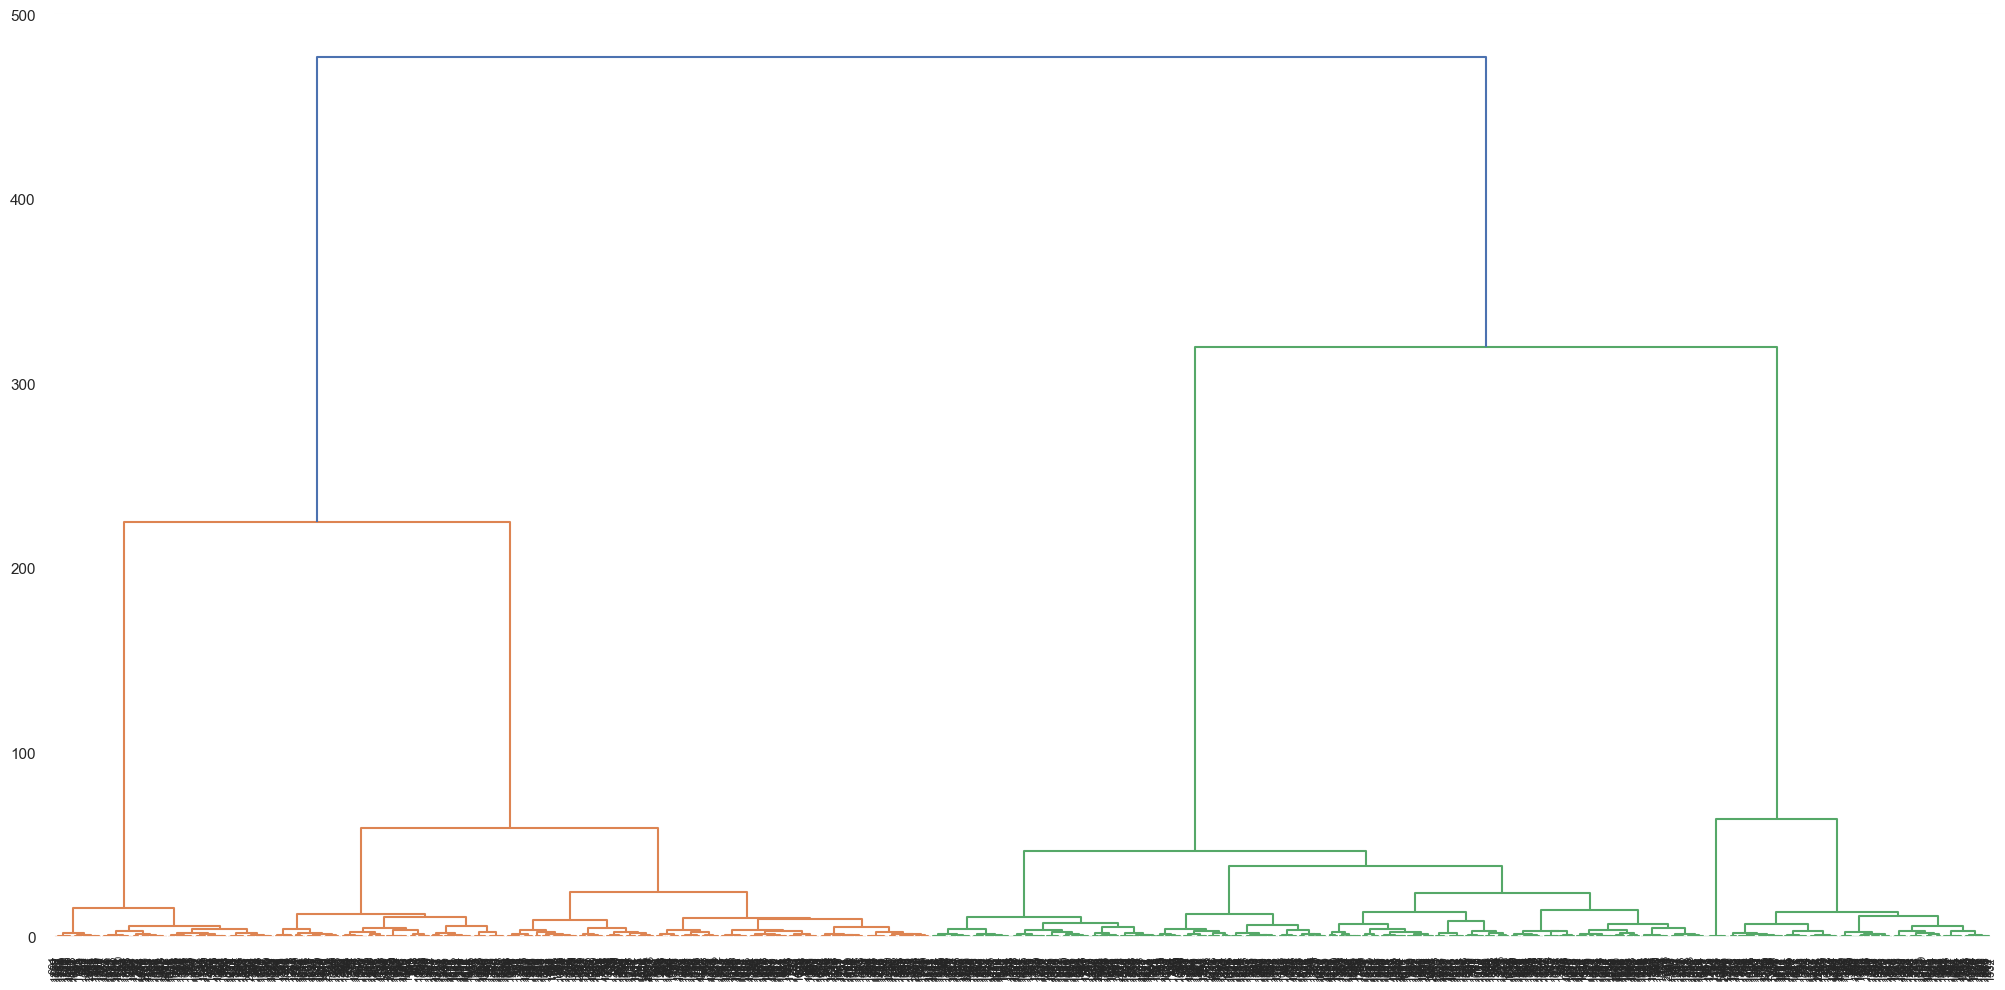

In [90]:
hr.dendrogram(hc_model,
             leaf_rotation=90,
             leaf_font_size=8)
plt.plot();

In [91]:
hc_list = []
for k in clusters:
    # model definition
    hc_model = hr.linkage(X,'ward')

    #model predict
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace
    hc_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

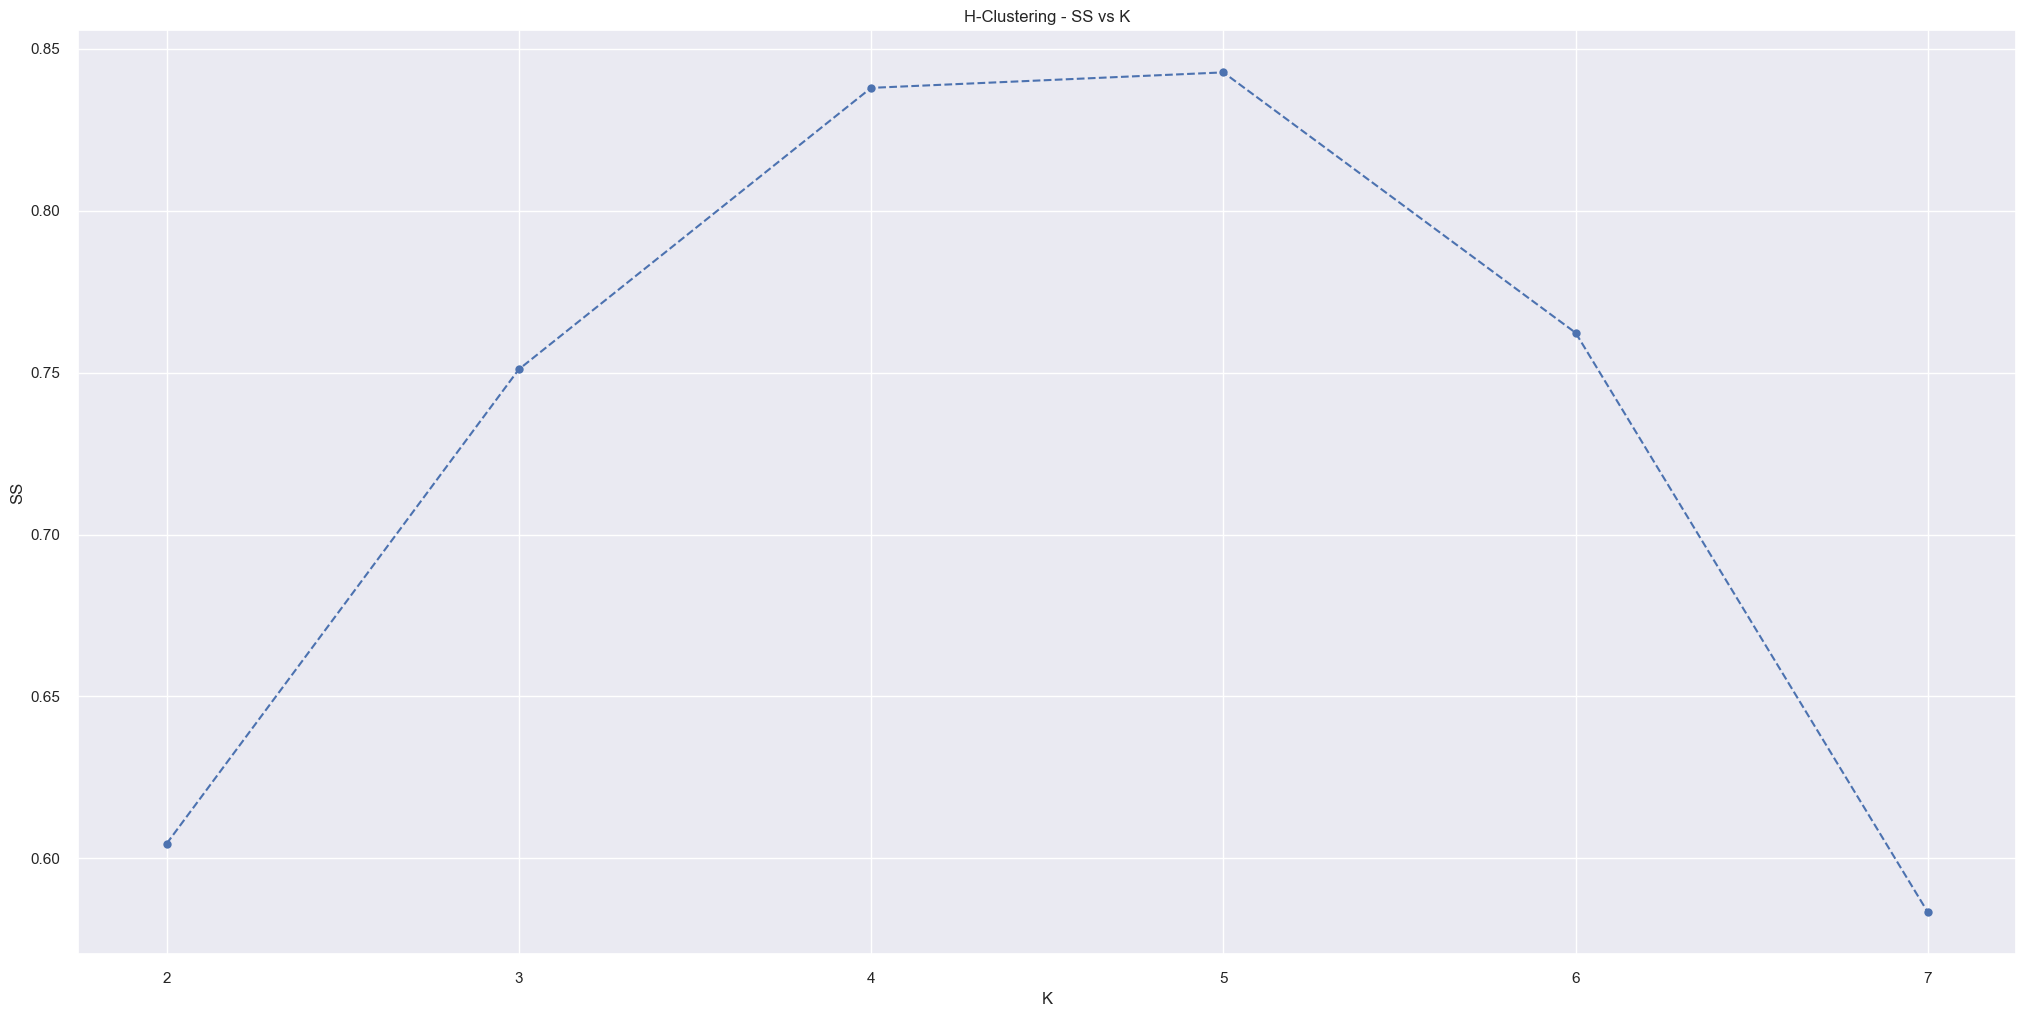

In [92]:
plt.plot(clusters,hc_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('H-Clustering - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.6045177578926086
For K = 3 Silhouette: 0.7510413527488708
For K = 4 Silhouette: 0.8379771113395691
For K = 5 Silhouette: 0.8427585959434509
For K = 6 Silhouette: 0.7623208165168762
For K = 7 Silhouette: 0.5833168029785156


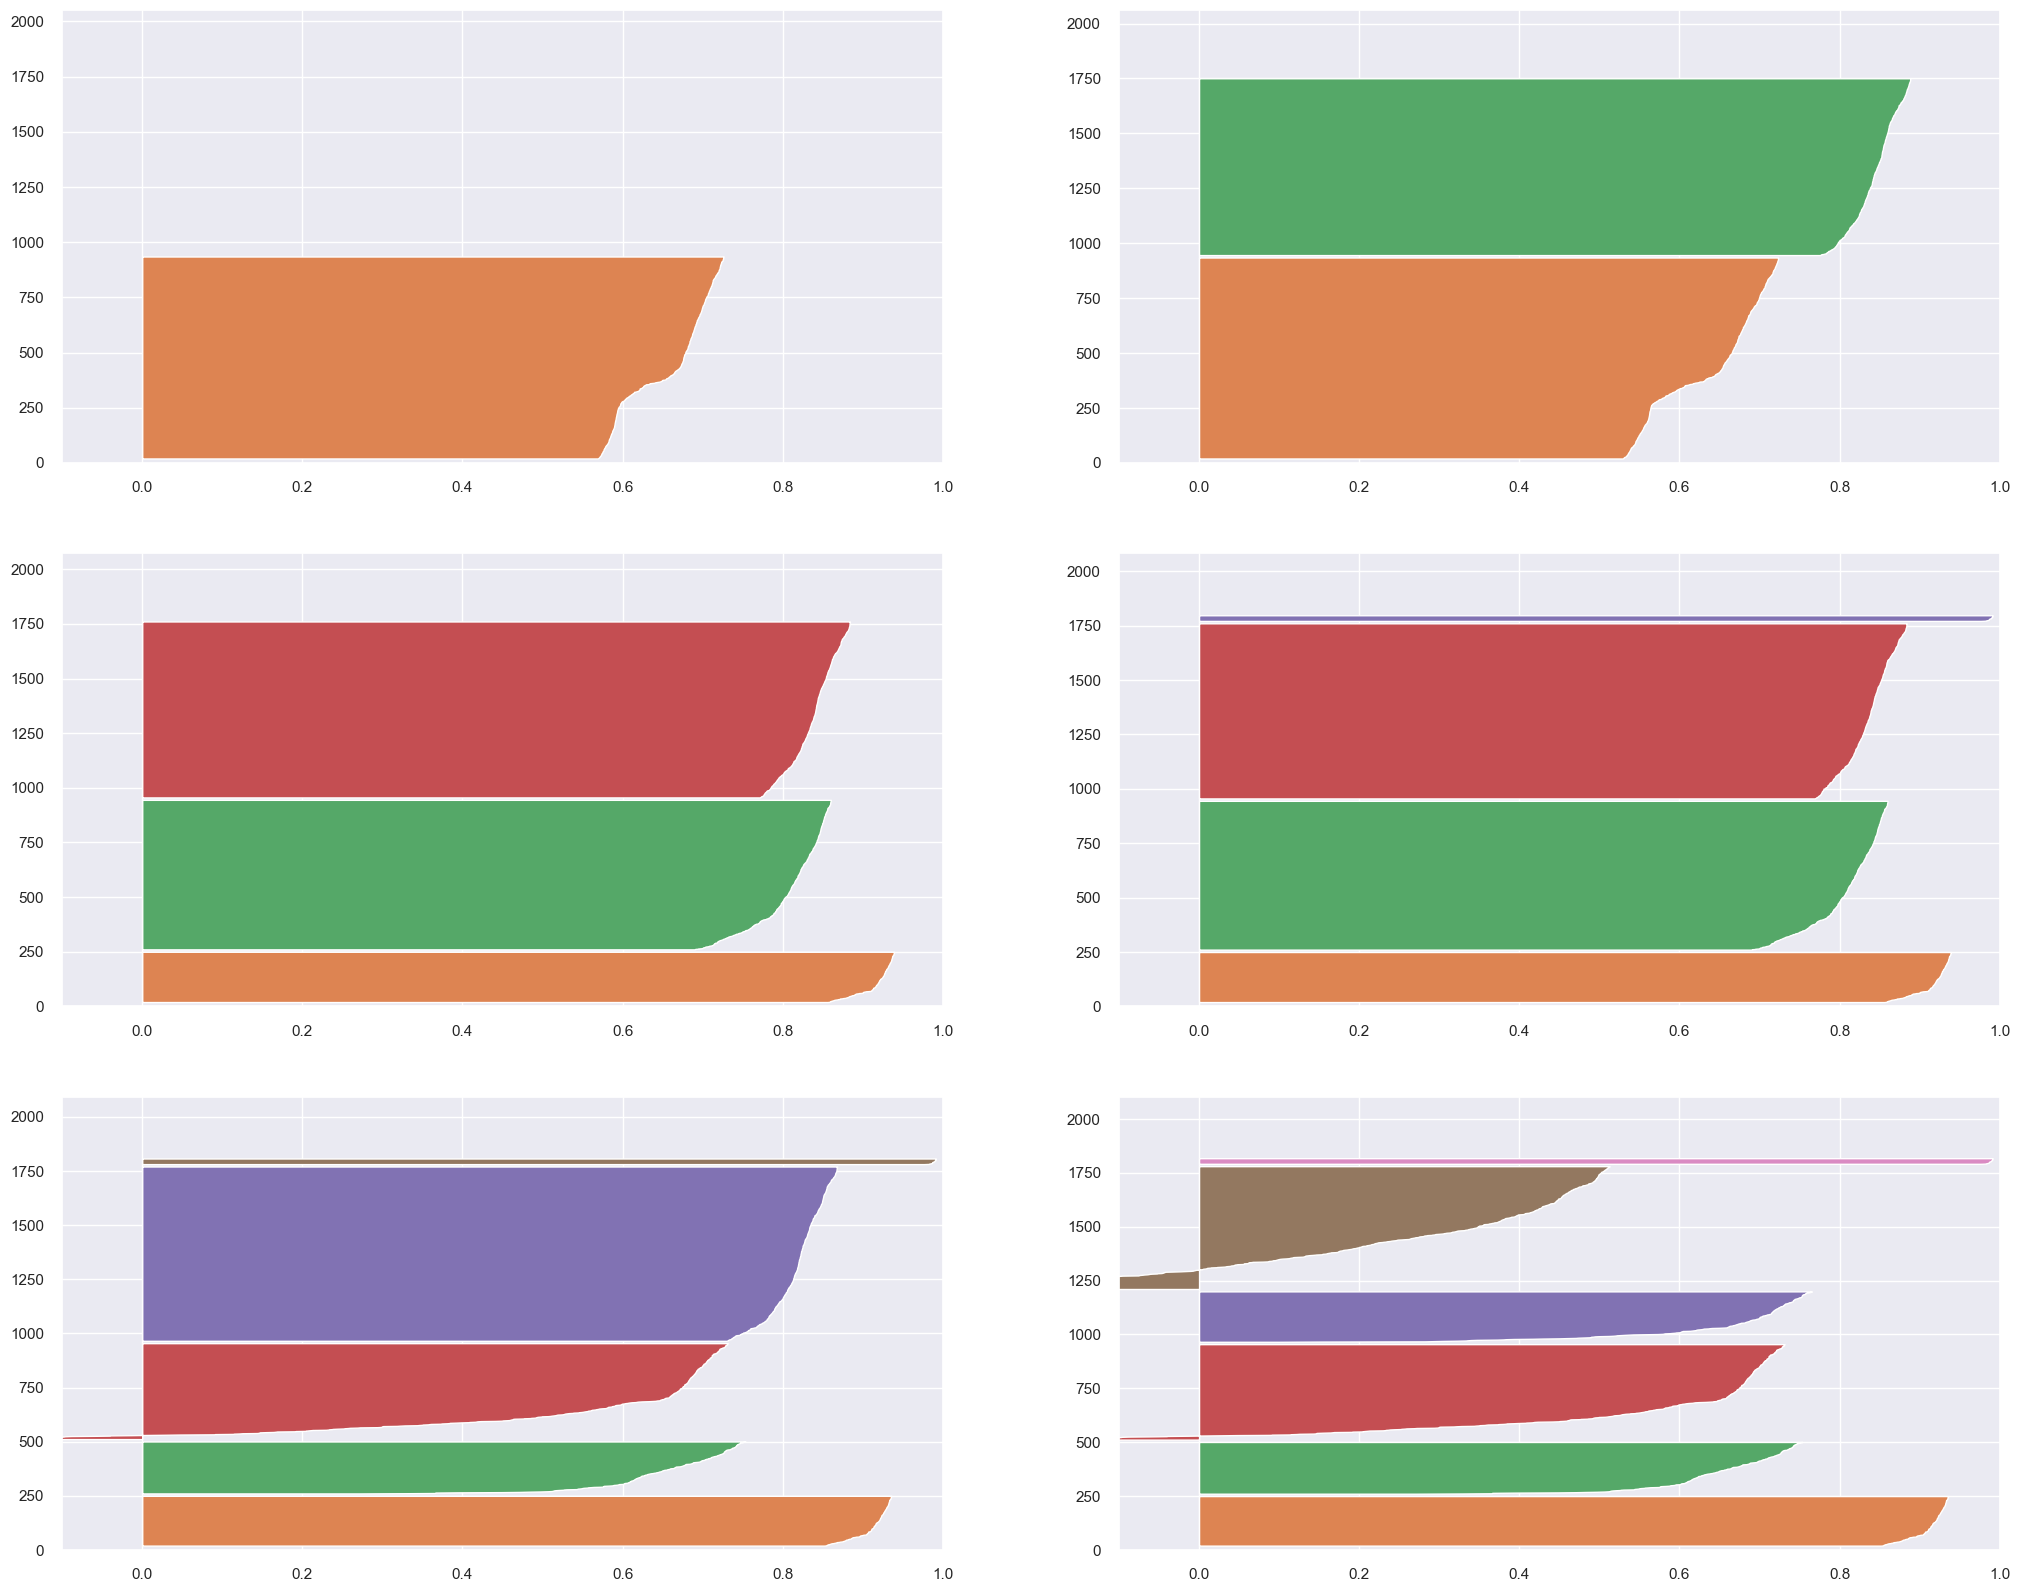

In [93]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition    
    hc_model = hr.linkage(X,'ward')

    #model predict    
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace    
    hc_k = (sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))
    print(f'For K = {k} Silhouette: {hc_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## Results

In [94]:
# Model name | k=2 | k=3 | k=4 | k=5
# Kmeans        ss    ss    ss    ss
# GMM           ss    ss    ss    ss
# HC            ss    ss    ss    ss
# DBSCAN        ss    ss    ss    ss

df_results = pd.DataFrame({
    'Kmeans': sil_k,
    'GMM': gmm_list,
    'HC': hc_list,
}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7
Kmeans,0.604518,0.751041,0.837977,0.842759,0.764248,0.594458
GMM,0.604518,0.751041,0.837977,0.842759,0.585364,0.593170
HC,0.604518,0.751041,0.837977,0.842759,0.762321,0.583317


# Model training

In [111]:
#model training
k = 5
kmeans = c.KMeans(n_clusters=k,random_state=42)
#model training
kmeans.fit(X)
#clustering
labels = kmeans.labels_

### Cluster validation

In [112]:
# WSS
print('WSS value',kmeans.inertia_)

## SS (Silhouette Score)
print('SS value',sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

WSS value 5643.04833984375
SS value 0.8427586


### Cluster analysis

In [113]:
df9 = df8.copy()
df9['clusters'] = labels

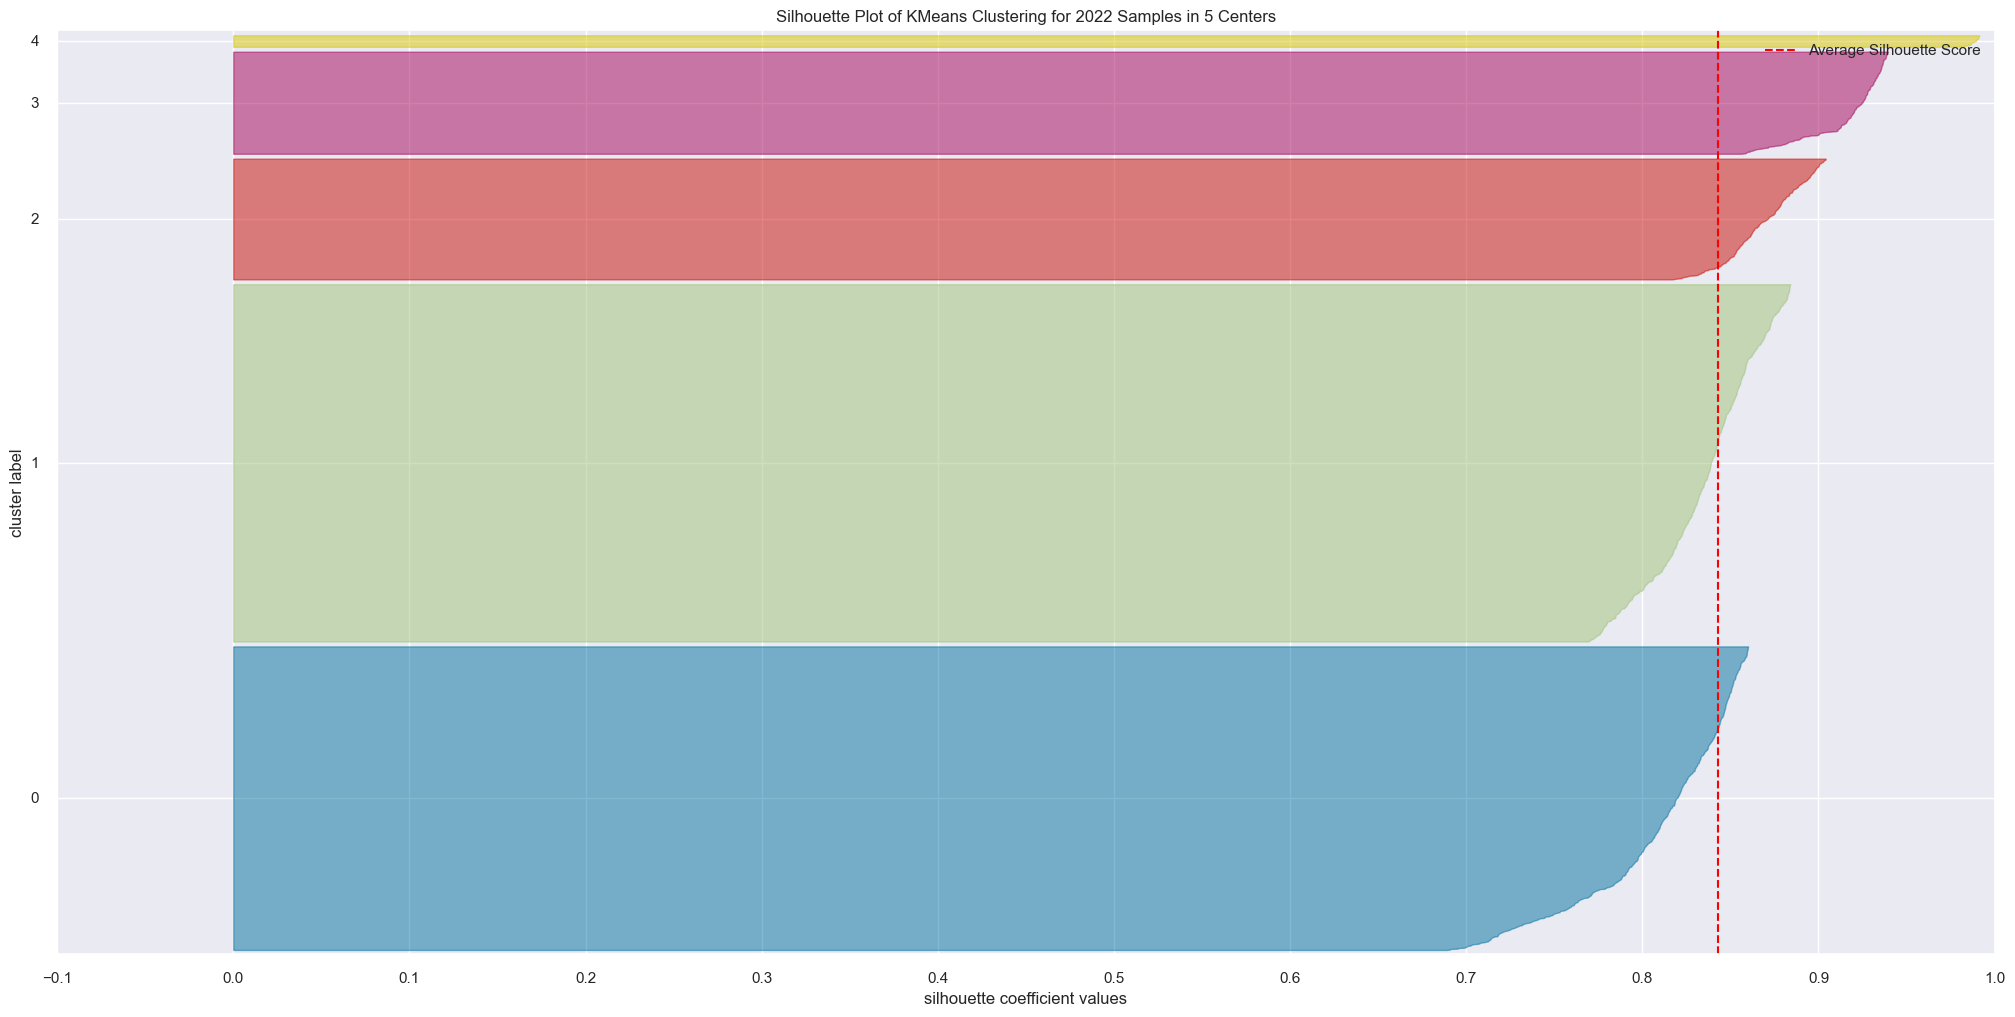

In [114]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

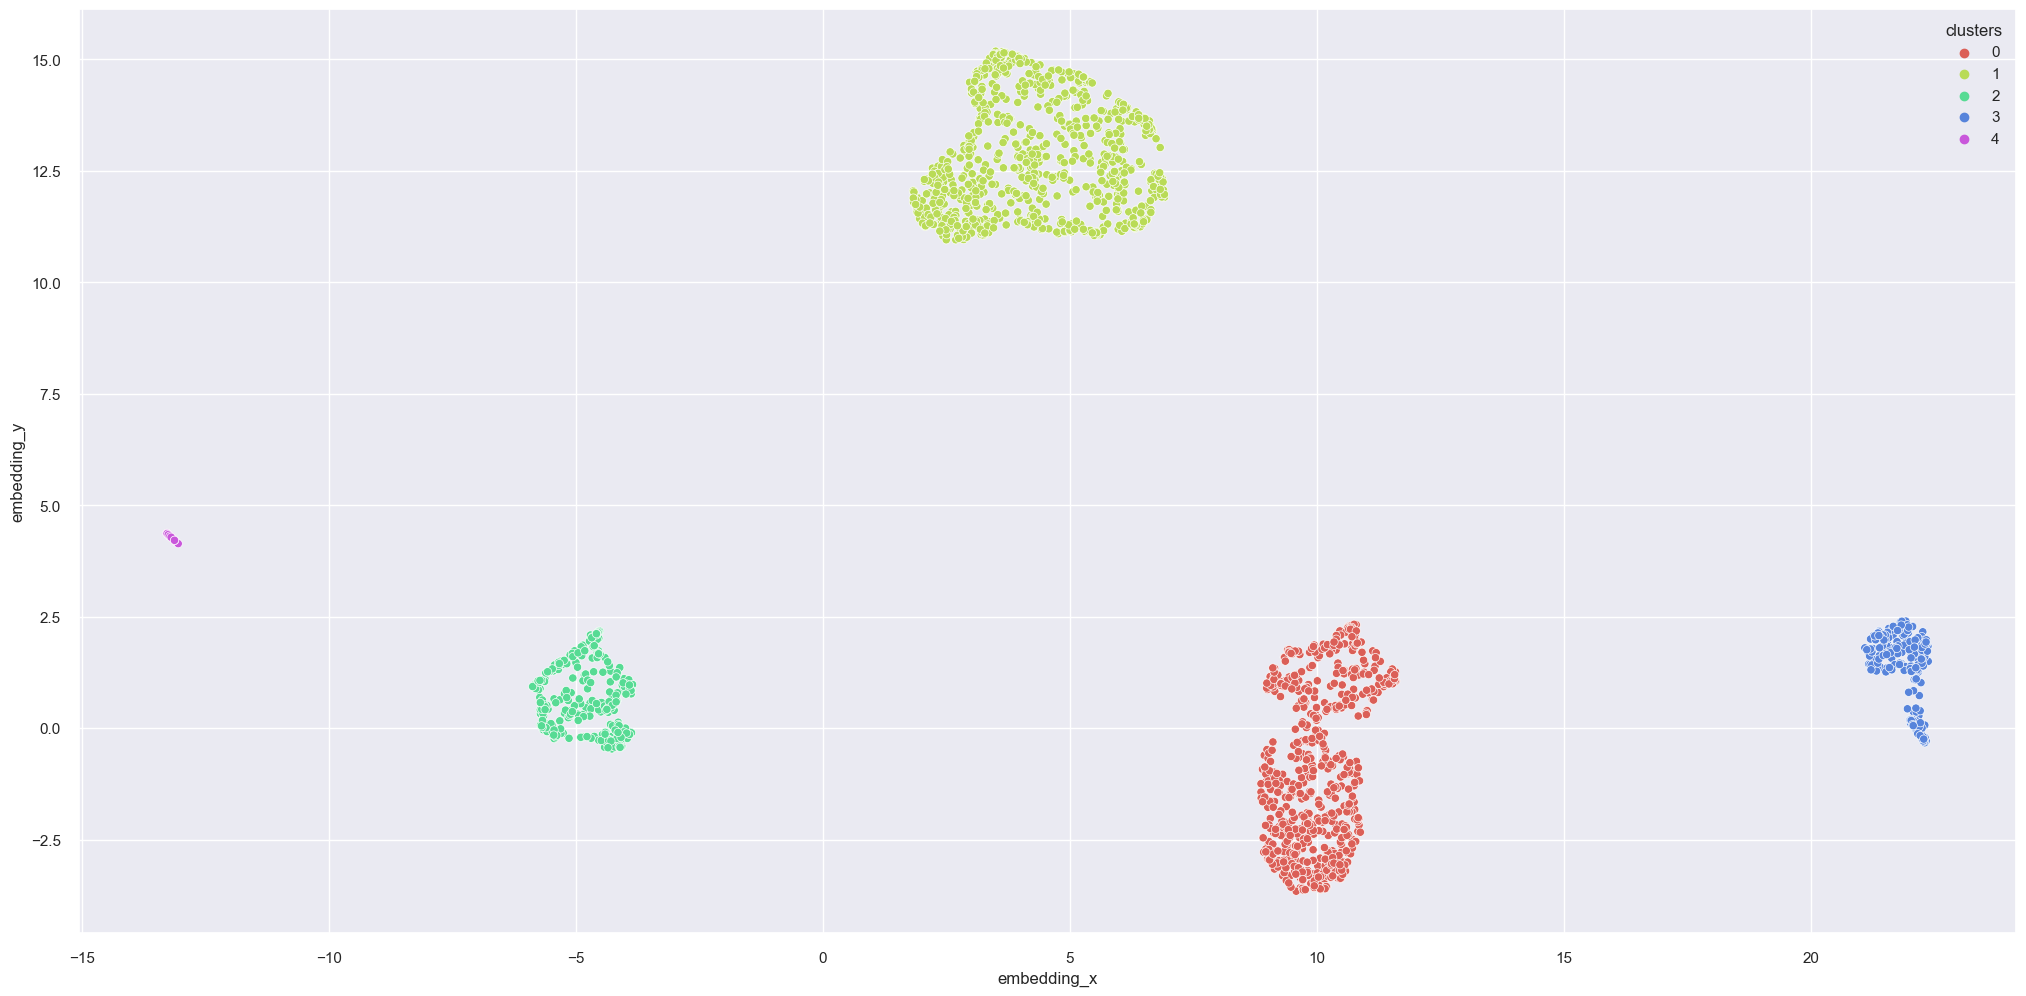

In [115]:
# reducer = umap.UMAP(n_neighbors=100,random_state=42)
# embedding = reducer.fit_transform(X)

df_viz = X.copy()
df_viz['clusters'] = labels
# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='clusters', palette=sns.color_palette('hls',n_colors=len(df_viz['clusters'].unique())),data = df_viz)

# Cluster profile

In [116]:
df10 = pd.read_csv(path_local+'src/data/df_prep.csv')
df10 = df10[cols_selected]
df10['clusters'] = labels

In [117]:
# number of customers
df_cluster = df10[['id','clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer_%'] = np.round_((df_cluster['id']/df_cluster['id'].sum())*100,2)

# Loop para iterar sobre as variáveis
for var in ['income','recency', 'mnt_wines', 'mnt_fruits','mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products','mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',            'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month','age', 'n_family_members', 'days_since_signup', 'income_per_member','total_spent']:
    
    df_avg_var = df10[[var,'clusters']].groupby('clusters').mean().reset_index()
    df_cluster = pd.merge(df_cluster, df_avg_var, how='inner', on='clusters')


In [118]:
pd.set_option('display.max_columns', None)
df_cluster.sort_values(by='total_spent',ascending=False)

,clusters,id,perc_customer_%,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,age,n_family_members,days_since_signup,income_per_member,total_spent
3,3,231,11.42,65577.948052,50.562771,495.454545,51.670996,372.125541,71.961039,54.043290,64.588745,1.203463,4.493506,4.575758,7.350649,3.731602,51.008658,1.0,347.043290,65577.948052,1109.844156
0,0,685,33.88,56110.162044,47.483212,377.461314,36.284672,230.265693,52.740146,36.451095,50.972263,1.807299,4.356204,3.443796,6.381022,4.702190,50.864234,2.0,363.744526,28055.081022,784.175182
1,1,806,39.86,46808.433002,48.642680,248.595533,17.374690,91.727047,24.418114,18.750620,39.367246,2.594293,4.140199,1.934243,5.384615,5.959057,50.105459,3.0,350.447891,15602.811001,440.233251
4,4,27,1.34,47058.555556,55.740741,198.925926,7.000000,65.296296,7.037037,4.333333,19.888889,3.629630,2.888889,1.000000,3.703704,6.000000,56.074074,5.0,324.592593,9411.711111,302.481481
2,2,273,13.50,45228.384615,51.157509,145.673993,7.827839,50.809524,10.934066,8.714286,22.871795,3.604396,3.186813,1.095238,4.450549,6.377289,54.384615,4.0,335.032967,11307.096154,246.831502


3 - Buyers

0 - olders

1 - army

4 - Smallville

2 - great family